# **XGBoost Modeling Pipeline — Baseline, Tuning, and Comparison**

## 1️⃣ Notebook Overview

This notebook uses the `XGBoostRunner` class to:

- Prepare filtered, feature‑engineered data for XGBoost
- Train a **baseline** XGBoost model
- Run **GridSearchCV**, **RandomizedSearchCV**, and **Hyperopt** tuning
- Evaluate and compare all variants (RMSE, MAE, R²)
- Analyze **feature importance** and **residuals**
- Generate **publication‑ready visualizations** and persist results/models

The goal is a clear, reproducible XGBoost benchmark for the selected store(s) and item(s).


## 2️⃣ Environment and project context

In this section we:

- Import core utilities and configuration
- Confirm project paths and environment
- Briefly restate the modeling objective for the Guayas region

We assume the project structure is already set up and that the feature engineering pipeline 
has produced a `final_train_dataset.csv` for week 3.

### *2.1 configuration*

In [1]:
import os
import sys



os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# --- Setup ---
%load_ext autoreload
%autoreload 2
%matplotlib inline

bad_paths = [
    "/Users/guykaptue/my_work_spaces/machine learning",
    "/Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/src"
]
sys.path = [p for p in sys.path if os.path.abspath(p) not in bad_paths]

print("Clean sys.path:")

Clean sys.path:


In [2]:
import os
import sys
from IPython.display import display
import plotly.offline as pyo

pyo.init_notebook_mode(connected=True)

# ------------------------------------------------------------
# 1️⃣ Determine project root dynamically
# ------------------------------------------------------------
cwd = os.getcwd()
print("Current working directory:", cwd)

# Go up THREE levels to reach retail_demand_analysis
project_root = os.path.abspath(os.path.join(cwd, "../../.."))
print("Project root:", project_root)

# ------------------------------------------------------------
# 2️⃣ Add project root to sys.path
# ------------------------------------------------------------
# ------------------------------------------------------------
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Project root added to sys.path:", project_root)

# ------------------------------------------------------------
# 3️⃣ Verify src is importable
# ------------------------------------------------------------
src_path = os.path.join(project_root, "src")
print("Does src exist?", os.path.exists(src_path))

Current working directory: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/notebooks/week_3/ml
Project root: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis
Project root added to sys.path: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis
Does src exist? True


In [3]:
# Verify that src is importable
try:
    import src
    print("✅ src module found at:", src.__file__)
except ModuleNotFoundError:
    print("❌ src module not found. Check your sys.path!")


📌 Plot 7 — 120-Day Linear Trend
✅ src module found at: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/src/__init__.py


### *2.2 Environment and imports*

In [4]:
# ================================================================
# 📦 2.2. Import Libraries and Environment Setup
# This cell loads all required libraries and configures the notebook
# environment for professional forecasting workflows.
# ================================================================

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src import XGBoostRunner



warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

print("✅ Environment initialized successfully")
print(f"Pandas: {pd.__version__}, NumPy: {np.__version__}")



✅ Environment initialized successfully
Pandas: 2.3.3, NumPy: 2.3.5


### *2.3 Configuration*

In this section we define:

- The **week** (for path routing and experiment grouping)
- The **data file** and **max_date** cutoff
- The **store_ids** and **item_ids** we want to model
- The **load_mode** and folder structure used by `DataPreparer`

These settings control which subset of the data is loaded and how the pipeline behaves.


In [5]:
# Core configuration for this run
WEEK = 3
FILENAME = "final_train_dataset.csv"
MAX_DATE = "2016-12-31"

LOAD_MODE = "csv_filter"      # as used in DataPreparer
FILTER_FOLDER = "filtered"
FOLDER_NAME = "features"

# Focused modeling scope (can be expanded to multiple stores/items)
STORE_IDS = [24]
ITEM_IDS = [105577]

VERBOSE = True


## 3️⃣ Initialize the XGBoostRunner

This step:

- Loads the ML configuration (`MLConfig`)
- Prepares the data via `DataPreparer.prepare_for_model("XGBRegressor")`
- Builds the preprocessing pipeline
- Sets up result, visualization, and model directories
- Initializes the `ModelVisualizer` with test indices and metadata

The printed summary gives us a quick sanity check on shapes and paths.


In [6]:
xgb_runner = XGBoostRunner(
    week=WEEK,
    filename=FILENAME,
    max_date=MAX_DATE,
    load_mode=LOAD_MODE,
    filter_folder=FILTER_FOLDER,
    folder_name=FOLDER_NAME,
    store_ids=STORE_IDS,
    item_ids=ITEM_IDS,
    verbose=VERBOSE,
)


🚀 Initializing XGBoostRunner...
📂 Setting up paths for results, visualizations, and models...
📋 Loading ML configuration...
📊 Preparing data for modeling...
Initializing DataPreparer...
Max date set to: 2016-12-31 00:00:00
Loading data from DataLoader...
🔧 DataLoader initialized with empty cache.
📌 Using loader: load_filtered_csv()
⚡ Loading existing filtered dataset: final_train_dataset__MAXDATE-2016-12-31__STORE-24__ITEM-105577.csv
✅ Loaded filtered dataset with shape: (1460, 44)

📅 Date Range:
   Start: 2013-01-02
   End:   2016-12-31
   Days:  1460
Data loaded with shape: (1460, 44)
Data shape after initialization: (1460, 45)
Data columns: ['store_nbr', 'item_nbr', 'date', 'id', 'unit_sales', 'onpromotion', 'year', 'month', 'day', 'day_of_week', 'week_of_year', 'quarter', 'is_weekend', 'day_of_year', 'unit_sales_lag_3', 'unit_sales_lag_7', 'unit_sales_lag_14', 'unit_sales_lag_30', 'unit_sales_lag_365', 'unit_sales_lag_same_dow_last_year', 'unit_sales_r3_mean', 'unit_sales_r7_mean',

### +3.1 Inspect prepared train/test data*

Before training, we quickly inspect:

- Train/test shapes
- Target distribution
- A few feature columns

This helps validate that the data preparation step is aligned with expectations.


In [7]:
print("Train shape:", xgb_runner.X_train.shape)
print("Test shape:", xgb_runner.X_test.shape)
print("Target:", xgb_runner.target)

display(xgb_runner.X_train.head())
display(xgb_runner.y_train.head())


Train shape: (1167, 14)
Test shape: (292, 14)
Target: unit_sales


onpromotion  unit_sales_lag_7  unit_sales_lag_14  unit_sales_lag_30  \
0            0               1.0                1.0                1.0   
1            0               1.0                1.0                1.0   
2            0               1.0                1.0                1.0   
3            0               1.0                1.0                1.0   
4            0               1.0                1.0                1.0   

   unit_sales_lag_365  unit_sales_r7_mean  unit_sales_r14_mean  \
0                 1.0                 1.0                  1.0   
1                 1.0                 1.0                  1.0   
2                 1.0                 1.0                  1.0   
3                 1.0                 1.0                  1.0   
4                 1.0                 1.0                  1.0   

   unit_sales_r30_mean  unit_sales_r7_std  day_of_week  month  \
0                  1.0                0.0            2      1   
1                  1.0                0.0            3      1   
2                  1.0                0.0            4      1   
3                  1.0                0.0            5      1   
4                  1.0                0.0            6      1   

   days_until_holiday  days_since_holiday  store_avg_sales  
0                   3                   1         3.461112  
1                   2                   2         3.461112  
2                   1                   3         3.461112  
3                   0                   4         3.461112  
4                   6                   1         3.461112

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: unit_sales, dtype: float64

## 4️⃣ TRAIN RANDOM FOREST VARIANTS

### *4.1 Baseline XGBoost model*

We first train a **baseline** XGBoost model using the default configuration from `MLConfig`.

This gives us:

- A reference performance (RMSE, MAE, R²)
- Saved results (JSON, MLflow logging)
- A persisted model (`xgboost.pkl`)
- Stored predictions for visualization


In [8]:
baseline_metrics = xgb_runner.train_baseline(save_model_flag=True)
baseline_metrics


🚀 Training baseline XGBoost...
   🛠️  Fitting the baseline model...
   ✓ Baseline model fitted.
   📈 Generating predictions for xgboost...
📊 xgboost → RMSE: 1.629, MAE: 1.223, R²: -0.007
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/xgboost/xgboost_results.json


2026/01/14 11:48:18 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/14 11:48:18 INFO mlflow.store.db.utils: Updating database tables
2026/01/14 11:48:18 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/14 11:48:18 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/14 11:48:18 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/14 11:48:18 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/14 11:48:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


📊 Metrics logged to MLflow under experiment 'XGBOOST'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/mlflow/xgboost_mlflow.json
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_3/xgboost/xgboost.pkl
✅ Model successfully saved.
⚠️  MLflow model logging failed: `_estimator_type` undefined.  Please use appropriate mixin to define estimator type.
Debug: Type of y_true: <class 'pandas.core.series.Series'>
Debug: Type of y_pred_series: <class 'numpy.ndarray'>
Debug: Length of y_true: 292
Debug: Length of y_pred_series: 292
Debug: Converting y_pred_series to pandas Series
Debug: min_len: 292
Debug: Length of y_true after slicing: 292
Debug: Length of y_pred_series after slicing: 292
Debug: Metrics for xgboost calculated successfully
✅ Baseline training complete.
   RMSE: 1.629, MAE: 1.223, R²:

{'rmse': 1.6290659376894394,
 'mae': 1.2234039457661596,
 'r2': -0.0073874580193278305,
 'variant': 'xgboost',
 'evaluation_time': '2026-01-14T11:48:18.367859'}

####  4.1.1  Baseline model analysis

We now generate diagnostic plots for the baseline model:

- Actual vs predicted
- Residuals analysis

These plots help us understand systematic errors and overall fit quality.



📊 Generating analysis plots for Baseline...
   📈 Actual vs Predicted...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/xgboost/05_actual_vs_predicted_xgboost.png


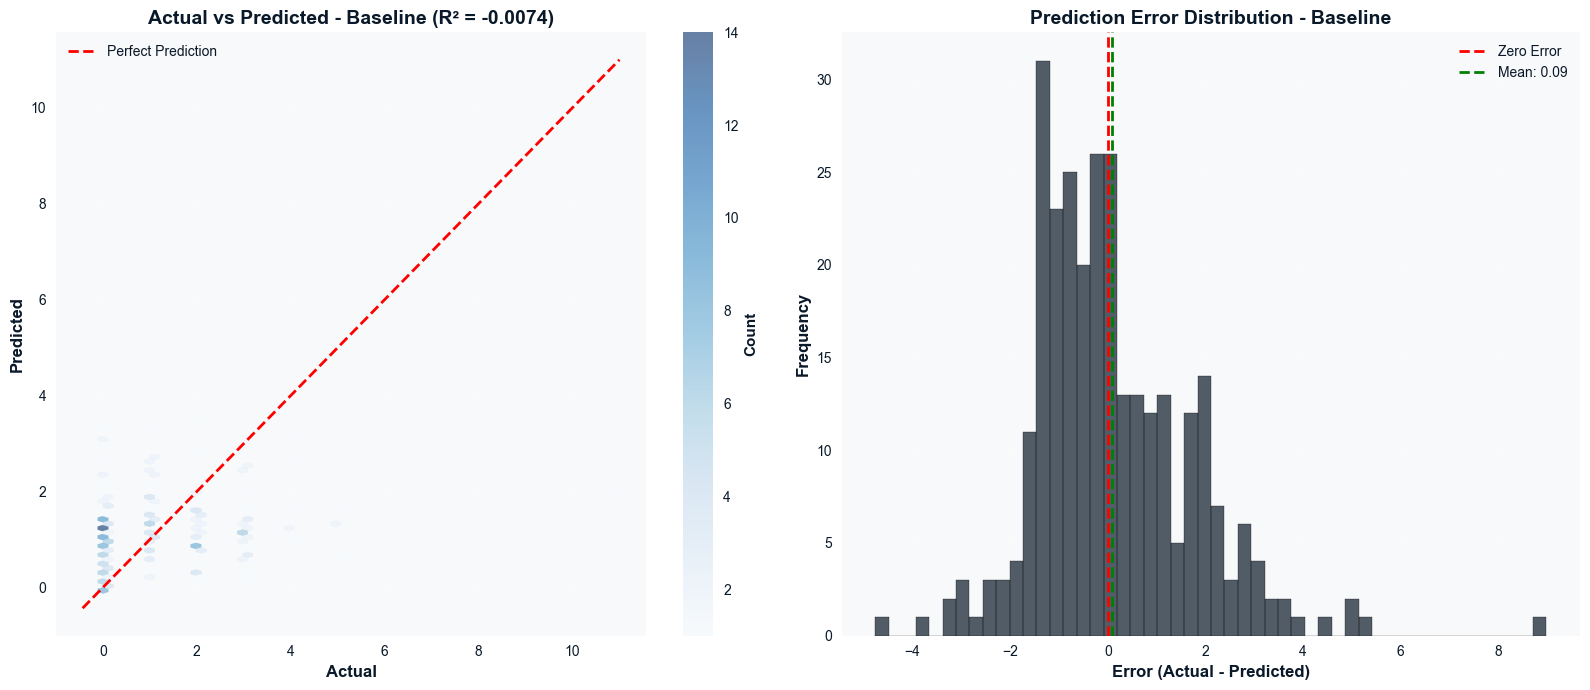

   📊 Residuals analysis...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/xgboost/06_residuals_analysis_xgboost.png


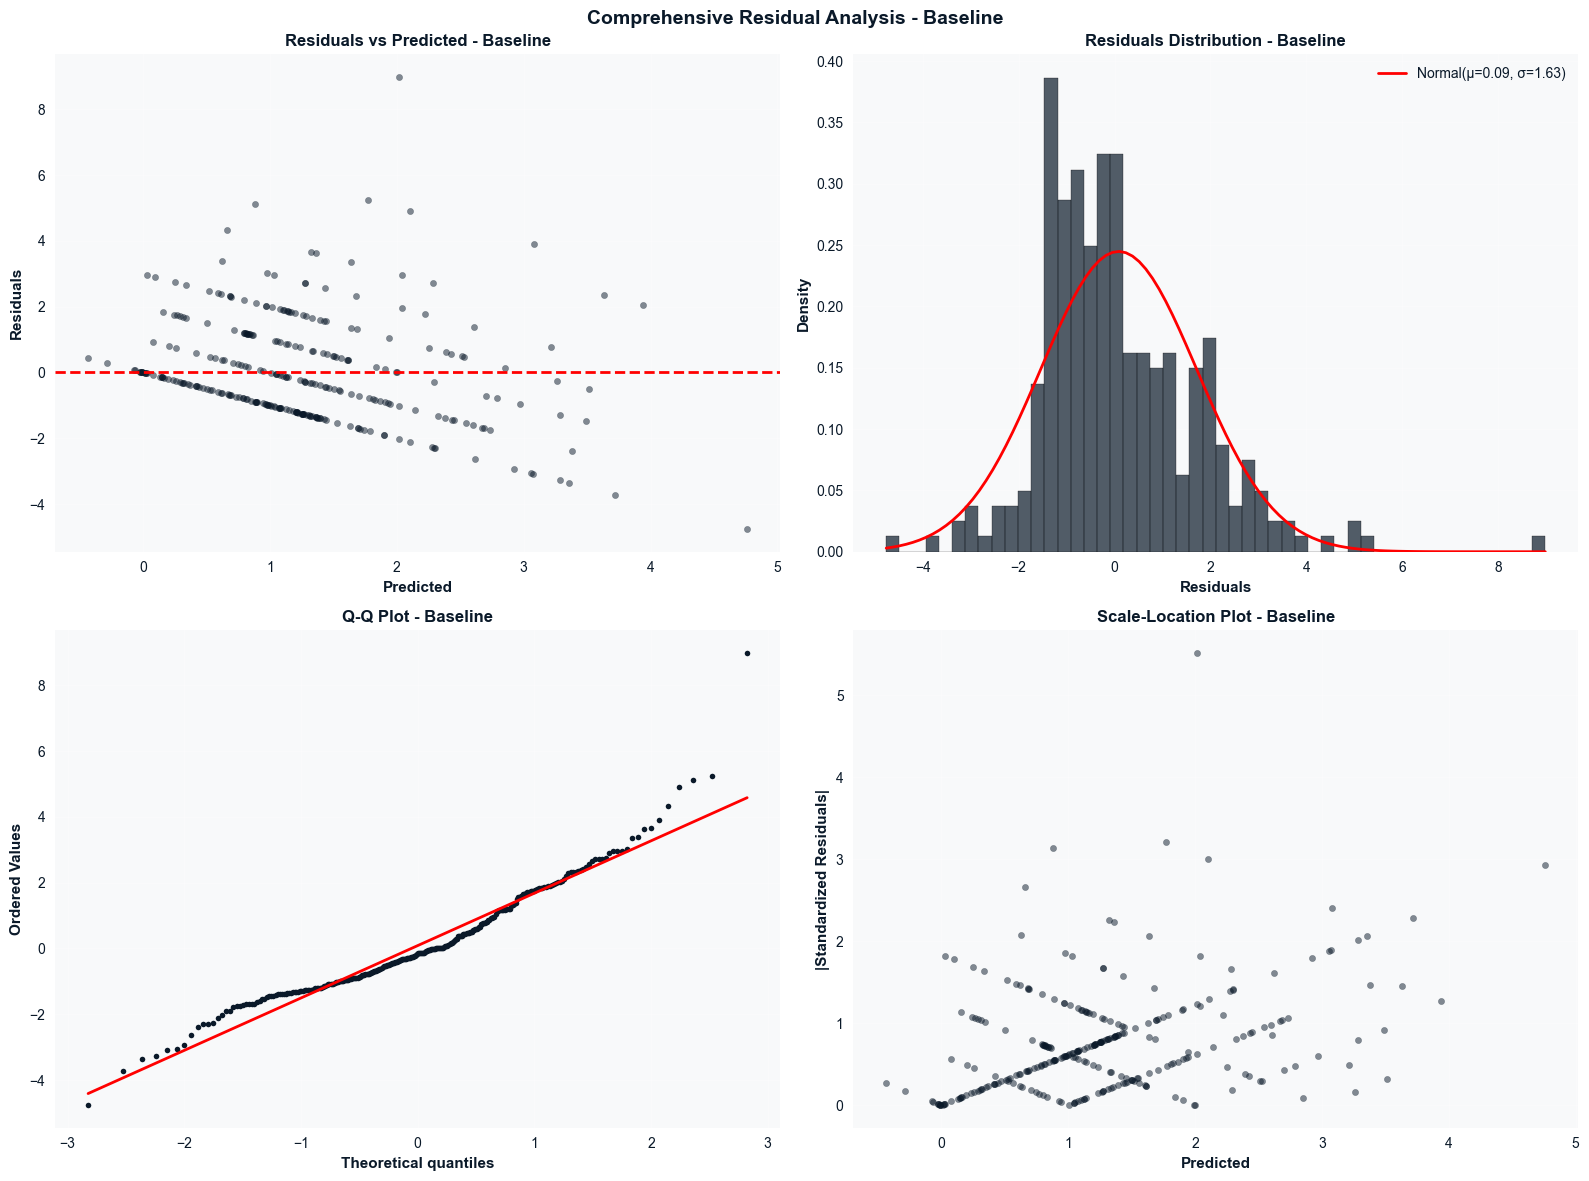

In [9]:
xgb_runner.plot_single_model_analysis(model_name="xgboost")


### *4.2 GridSearchCV tuning*

Next, we run **GridSearchCV** using the parameter grid defined in `MLConfig`:

- Cross‑validated search over a discrete grid
- Best parameters and best score (CV RMSE)
- Updated pipeline and predictions
- Results and model logged and saved

This is typically more expensive but structured.


In [10]:
grid_metrics = xgb_runner.train_gridsearch(save_model_flag=True)
grid_metrics


🔍 Running GridSearchCV for XGBoost...
   🔧 Setting up GridSearchCV with parameters: {'n_estimators': [300, 600], 'learning_rate': [0.03, 0.05, 0.1], 'max_depth': [6, 8, 10], 'subsample': [0.7, 0.8, 1.0], 'colsample_bytree': [0.7, 0.8, 1.0], 'reg_lambda': [0, 1, 5], 'reg_alpha': [0, 0.5, 1]}
   🛠️  Fitting GridSearchCV...
Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.03, max_depth=6, n_estimators=300, reg_alpha=0, reg_lambda=0, subsample=0.7;, score=-1.716 total time=   0.0s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.03, max_depth=6, n_estimators=300, reg_alpha=0, reg_lambda=0, subsample=0.7;, score=-1.632 total time=   0.0s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.03, max_depth=6, n_estimators=300, reg_alpha=0, reg_lambda=0, subsample=0.7;, score=-0.721 total time=   0.0s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.03, max_depth=6, n_estimators=300, reg_alpha=0, reg_lambda=0, subsample=0.7;, 

2026/01/14 12:02:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   ✓ GridSearchCV fitted.
✅ GridSearch complete. Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.7}
   Best score: 1.158
   📈 Generating predictions for xgboost_grid...
📊 xgboost_grid → RMSE: 1.610, MAE: 1.210, R²: 0.016
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/xgboost/xgboost_grid_results.json
📊 Metrics logged to MLflow under experiment 'XGBOOST'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/mlflow/xgboost_grid_mlflow.json
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_3/xgboost/xgboost_grid.pkl
✅ Model successfully saved.
⚠️  MLflow model logging failed: 'GridSearchCV' object ha

{'rmse': 1.6097804603538557,
 'mae': 1.2097802591256555,
 'r2': 0.016323000805306576,
 'variant': 'xgboost_grid',
 'evaluation_time': '2026-01-14T12:02:24.541134',
 'best_params': {'colsample_bytree': 0.8,
  'learning_rate': 0.03,
  'max_depth': 10,
  'n_estimators': 300,
  'reg_alpha': 0,
  'reg_lambda': 1,
  'subsample': 0.7}}


📊 Generating analysis plots for Grid Search...
   📈 Actual vs Predicted...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/xgboost/05_actual_vs_predicted_xgboost_grid.png


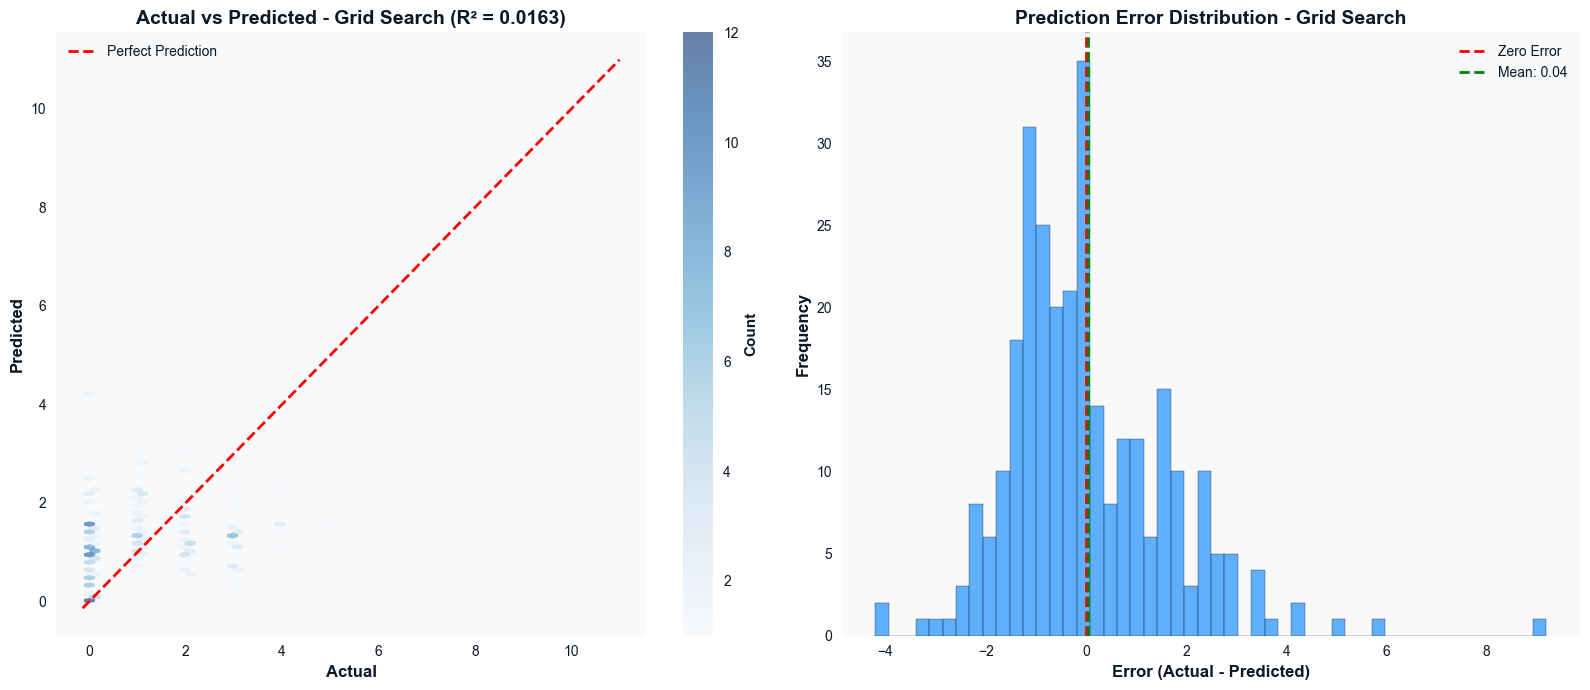

   📊 Residuals analysis...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/xgboost/06_residuals_analysis_xgboost_grid.png


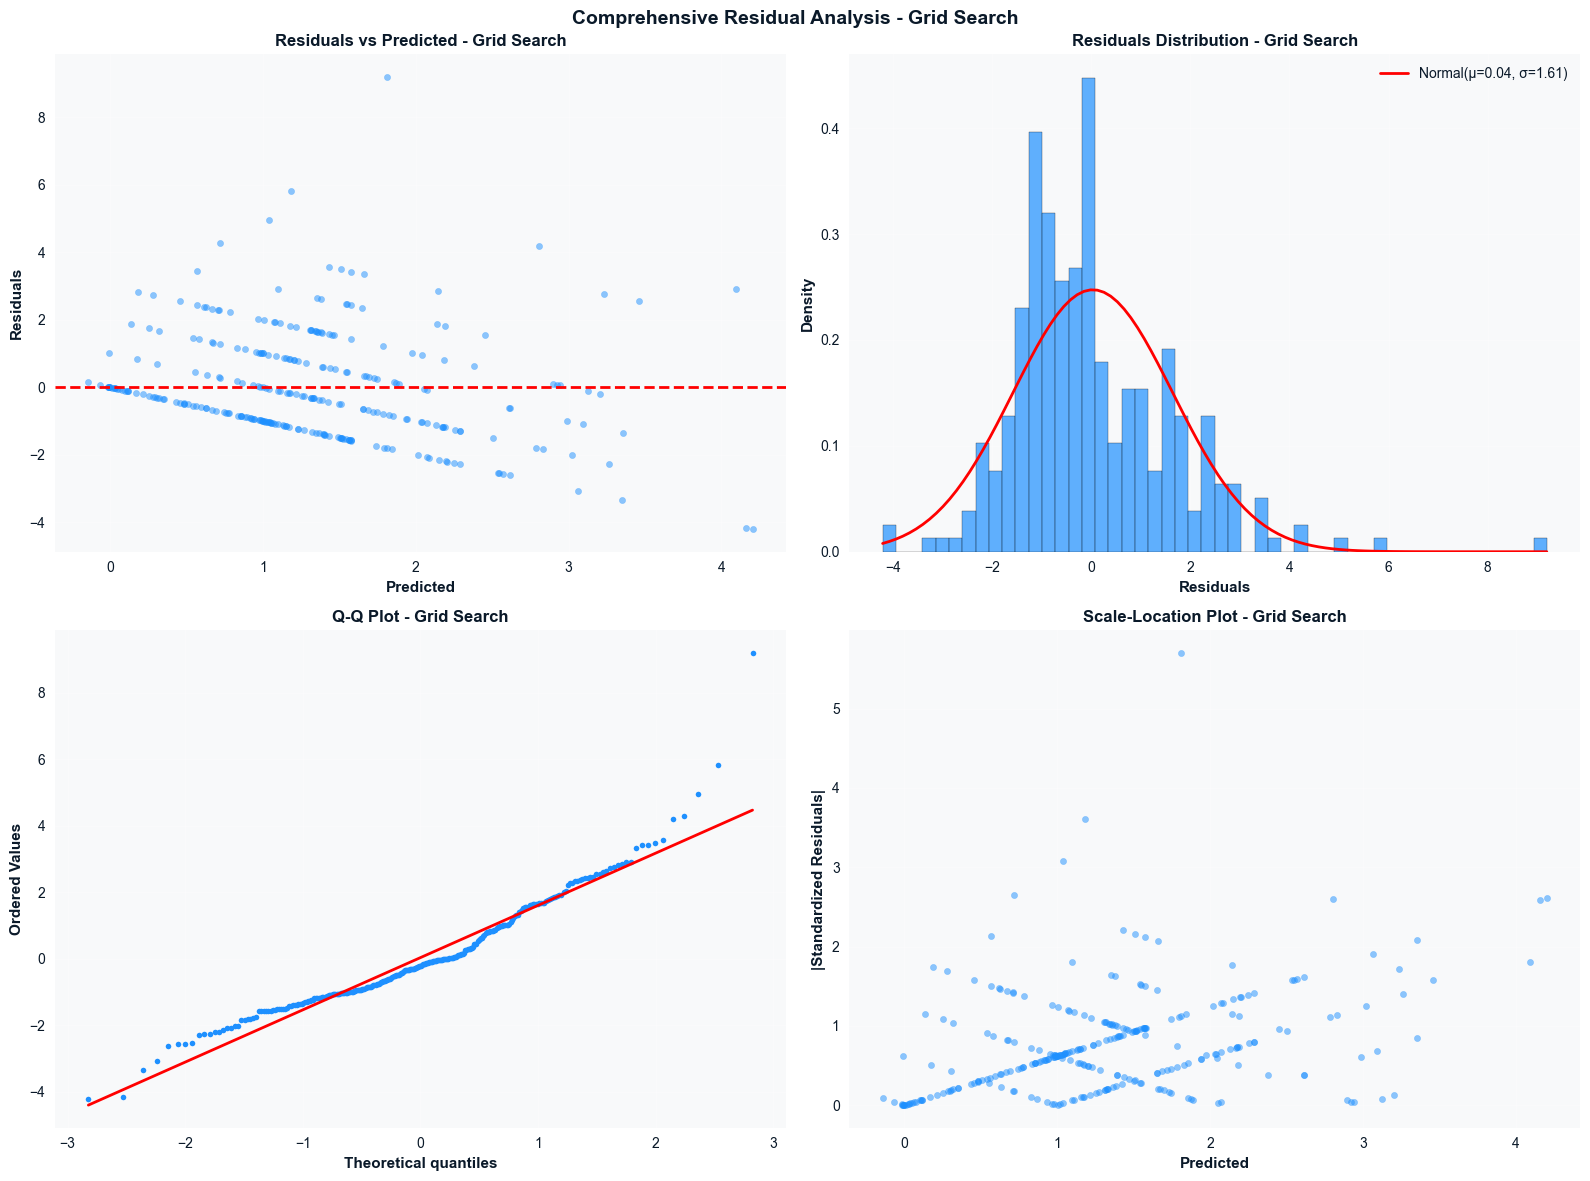

In [11]:
xgb_runner.plot_single_model_analysis(model_name="xgboost_grid")

### *4.3 RandomizedSearchCV tuning*

We then run **RandomizedSearchCV**:

- Samples parameter combinations from distributions
- Often more efficient for larger search spaces
- Returns best parameters and CV RMSE
- Saves tuned model and logs metrics

This provides a complementary tuning strategy to GridSearch.


In [12]:
random_metrics = xgb_runner.train_randomsearch(save_model_flag=True)
random_metrics


🎲 Running RandomizedSearchCV for XGBoost...
Debug param_dist: {'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17d86aa90>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x367b076d0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x367833350>, 'subsample': [0.6, 0.7, 0.8, 1.0], 'colsample_bytree': [0.6, 0.7, 0.8, 1.0], 'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x367b47990>, 'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x367c087d0>}
   🛠️  Fitting RandomizedSearchCV...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.08838704519727178, max_depth=10, n_estimators=406, reg_alpha=0.13145103232150107, reg_lambda=0.09643857615941427, subsample=0.7;, score=-1.686 total time=   0.1s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.08838704519727178, max_depth

2026/01/14 12:03:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.004204768770217896, max_depth=10, n_estimators=645, reg_alpha=0.00012629989039320005, reg_lambda=6.504921701204662, subsample=0.8;, score=-0.701 total time=   0.3s
   ✓ RandomizedSearchCV fitted.
✅ RandomSearch complete. Best params: {'colsample_bytree': 1.0, 'learning_rate': np.float64(0.007788255587326423), 'max_depth': 4, 'n_estimators': 335, 'reg_alpha': np.float64(0.15602015889668858), 'reg_lambda': np.float64(0.1777541111003925), 'subsample': 1.0}
   Best score: 1.141
   📈 Generating predictions for xgboost_random...
📊 xgboost_random → RMSE: 1.551, MAE: 1.155, R²: 0.086
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/xgboost/xgboost_random_results.json
📊 Metrics logged to MLflow under experiment 'XGBOOST'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand

{'rmse': 1.551489091719816,
 'mae': 1.1550867202602428,
 'r2': 0.08627256196167832,
 'variant': 'xgboost_random',
 'evaluation_time': '2026-01-14T12:03:14.537580',
 'best_params': {'colsample_bytree': 1.0,
  'learning_rate': np.float64(0.007788255587326423),
  'max_depth': 4,
  'n_estimators': 335,
  'reg_alpha': np.float64(0.15602015889668858),
  'reg_lambda': np.float64(0.1777541111003925),
  'subsample': 1.0}}


📊 Generating analysis plots for Random Search...
   📈 Actual vs Predicted...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/xgboost/05_actual_vs_predicted_xgboost_random.png


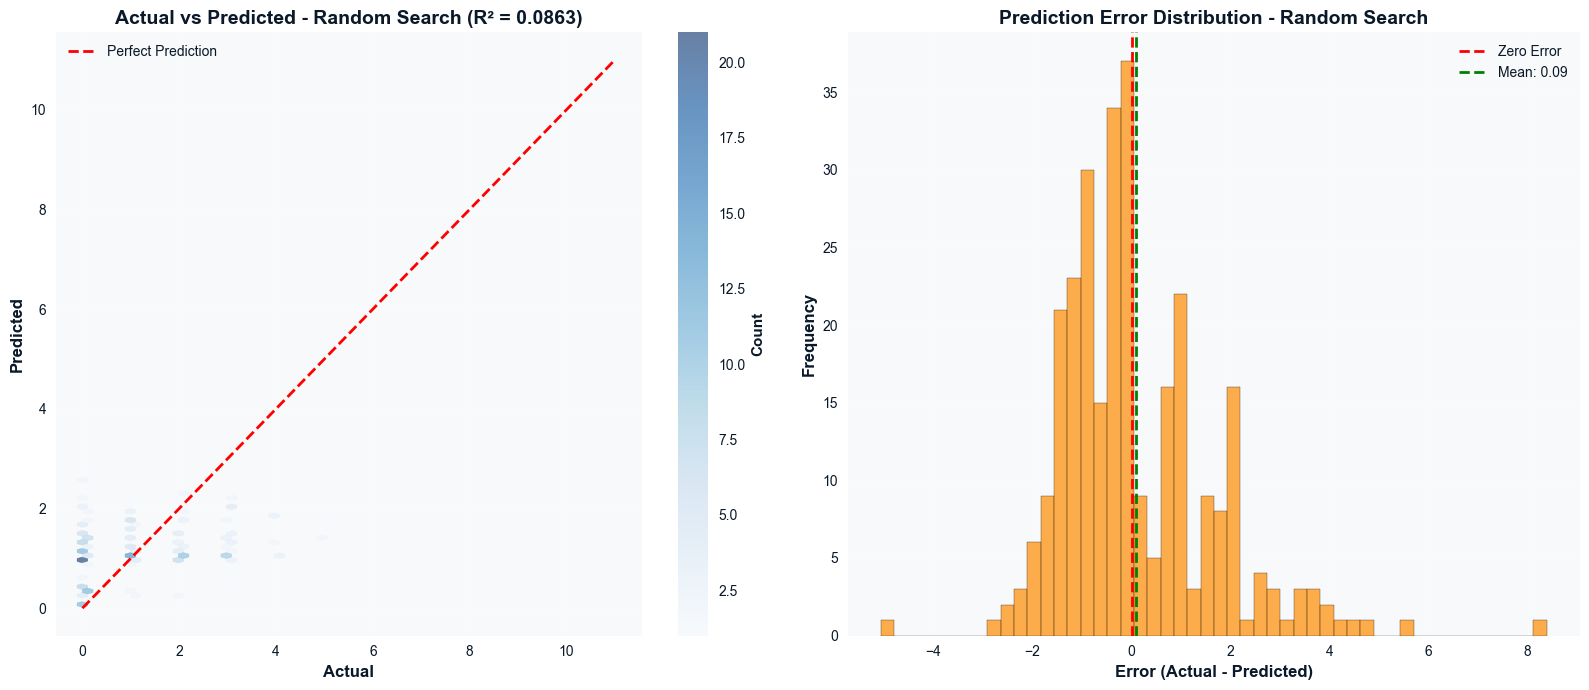

   📊 Residuals analysis...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/xgboost/06_residuals_analysis_xgboost_random.png


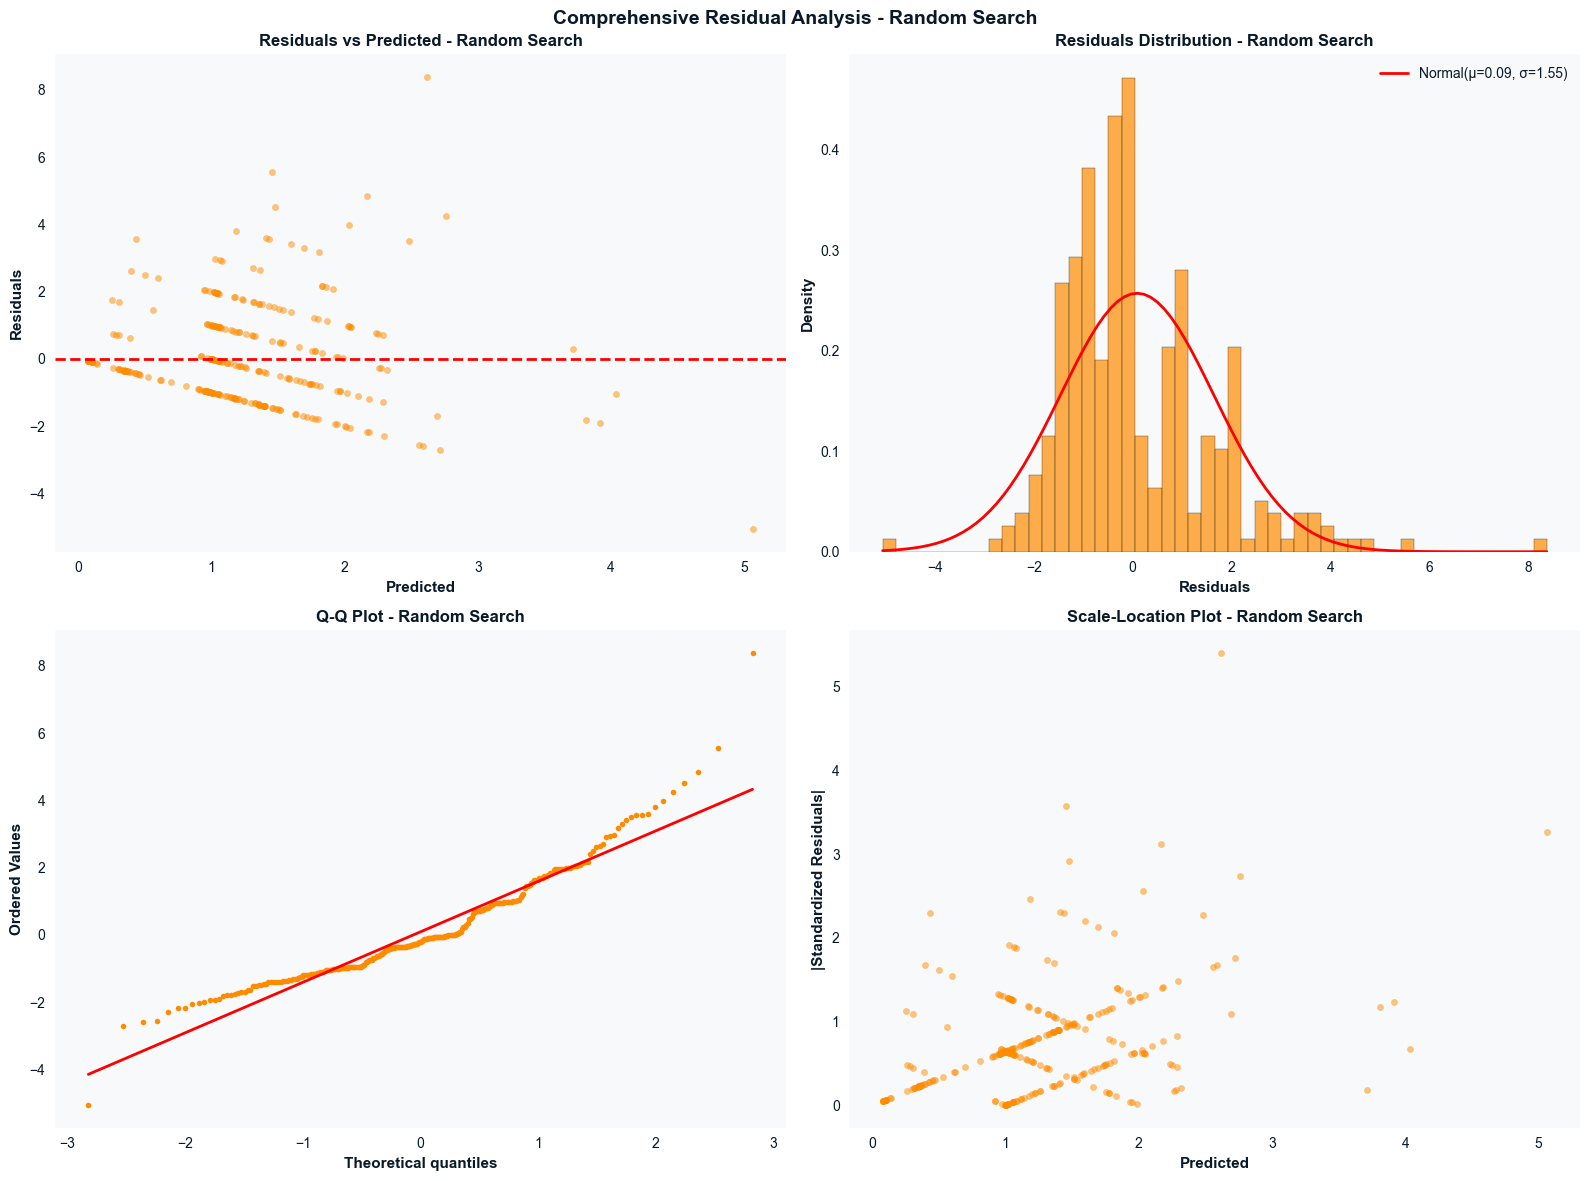

In [13]:
xgb_runner.plot_single_model_analysis(model_name="xgboost_random")

### *4.4 Hyperopt Bayesian optimization*

Finally, we use **Hyperopt** for Bayesian optimization:

- Search space defined in YAML via `MLConfig.get_model_cfg("xgboost")`
- Objective: minimize RMSE via cross‑validation
- `max_evals` controls the number of trials
- Best parameters are used to train a final tuned model

Hyperopt trials are also saved for later inspection.


In [ ]:
MAX_HYPEROPT_EVALS = 120  

hyperopt_metrics = xgb_runner.train_hyperopt(
    max_evals=MAX_HYPEROPT_EVALS,
    save_model_flag=True,
)
hyperopt_metrics


⚡ Running Hyperopt for XGBoost...
   🔧 Using Hyperopt with max_evals=120
   🚀 Starting Hyperopt optimization...
  0%|          | 0/120 [00:00<?, ?trial/s, best loss=?]

/opt/anaconda3/envs/retail_env/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/retail_env/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/retail_env/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this pack

      Hyperopt trial → params={'colsample_bytree': 0.8862233836452398, 'learning_rate': 0.0002661118719738877, 'max_depth': 10, 'n_estimators': 900, 'reg_alpha': 0.3437381698236853, 'reg_lambda': 0.1263585817849702, 'subsample': 0.9254621630561151}, RMSE=1.3884
  1%|          | 1/120 [00:04<08:17,  4.18s/trial, best loss: 1.3883968360745973]

/opt/anaconda3/envs/retail_env/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/retail_env/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


      Hyperopt trial → params={'colsample_bytree': 0.9539527896501707, 'learning_rate': 0.0001978795019380458, 'max_depth': 9, 'n_estimators': 350, 'reg_alpha': 0.2781931655713674, 'reg_lambda': 0.11023568272067896, 'subsample': 0.7201685419162033}, RMSE=1.4781
  2%|▏         | 2/120 [00:06<05:50,  2.97s/trial, best loss: 1.3883968360745973]

/opt/anaconda3/envs/retail_env/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


      Hyperopt trial → params={'colsample_bytree': 0.9564597038310891, 'learning_rate': 0.11162686071565248, 'max_depth': 9, 'n_estimators': 450, 'reg_alpha': 0.029672927872975607, 'reg_lambda': 0.0002357123841690817, 'subsample': 0.658785114914011}, RMSE=1.2382
      Hyperopt trial → params={'colsample_bytree': 0.6823764671265532, 'learning_rate': 0.007164533630347159, 'max_depth': 5, 'n_estimators': 950, 'reg_alpha': 0.023531187797091197, 'reg_lambda': 0.0011598052747189413, 'subsample': 0.7615110681047916}, RMSE=1.1793
      Hyperopt trial → params={'colsample_bytree': 0.8009517123900541, 'learning_rate': 0.0031334419836934746, 'max_depth': 7, 'n_estimators': 600, 'reg_alpha': 0.0014211031292886815, 'reg_lambda': 0.00030702340524058915, 'subsample': 0.8011615018645928}, RMSE=1.1535
      Hyperopt trial → params={'colsample_bytree': 0.7845735941946607, 'learning_rate': 0.012177667417365336, 'max_depth': 11, 'n_estimators': 950, 'reg_alpha': 0.005892230058953039, 'reg_lambda': 0.00064

2026/01/14 13:25:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   📈 Generating predictions for xgboost_hyperopt...
📊 xgboost_hyperopt → RMSE: 1.561, MAE: 1.177, R²: 0.076
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/xgboost/xgboost_hyperopt_results.json
📊 Metrics logged to MLflow under experiment 'XGBOOST'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/mlflow/xgboost_hyperopt_mlflow.json
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_3/xgboost/xgboost_hyperopt.pkl
✅ Model successfully saved.
⚠️  MLflow model logging failed: `_estimator_type` undefined.  Please use appropriate mixin to define estimator type.
Debug: Type of y_true: <class 'pandas.core.series.Series'>
Debug: Type of y_pred_series: <class 'numpy.ndarray'>
Debug: Length of y_true: 29

{'rmse': 1.5605925145808084,
 'mae': 1.17706344735949,
 'r2': 0.0755184412575356,
 'variant': 'xgboost_hyperopt',
 'evaluation_time': '2026-01-14T13:25:52.122929',
 'best_params': {'colsample_bytree': 0.678005662321192,
  'learning_rate': 0.00960677021066004,
  'max_depth': 7,
  'n_estimators': 300,
  'reg_alpha': 0.962188302583034,
  'reg_lambda': 0.00787106199242684,
  'subsample': 0.7414922190959902}}


📊 Generating analysis plots for Hyperopt...
   📈 Actual vs Predicted...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/xgboost/05_actual_vs_predicted_xgboost_hyperopt.png


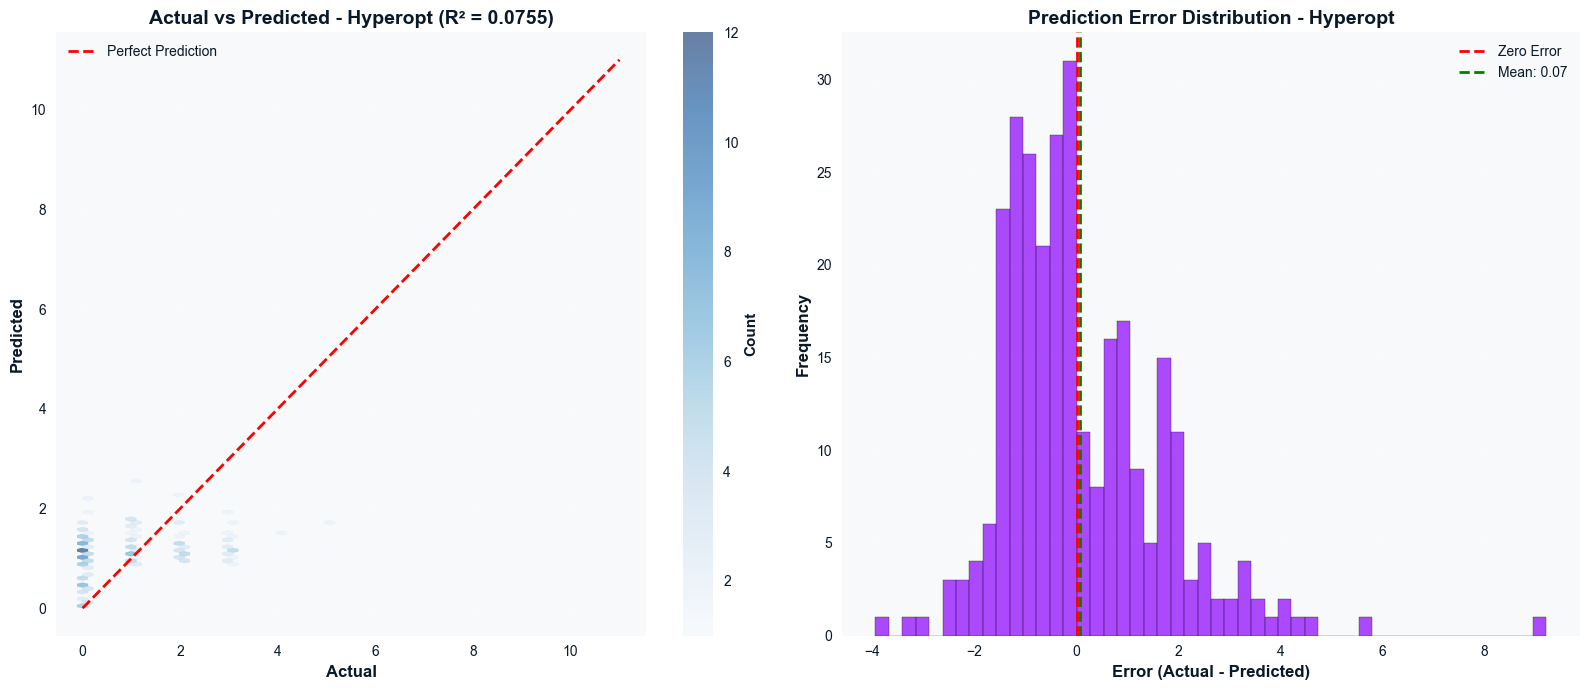

   📊 Residuals analysis...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/xgboost/06_residuals_analysis_xgboost_hyperopt.png


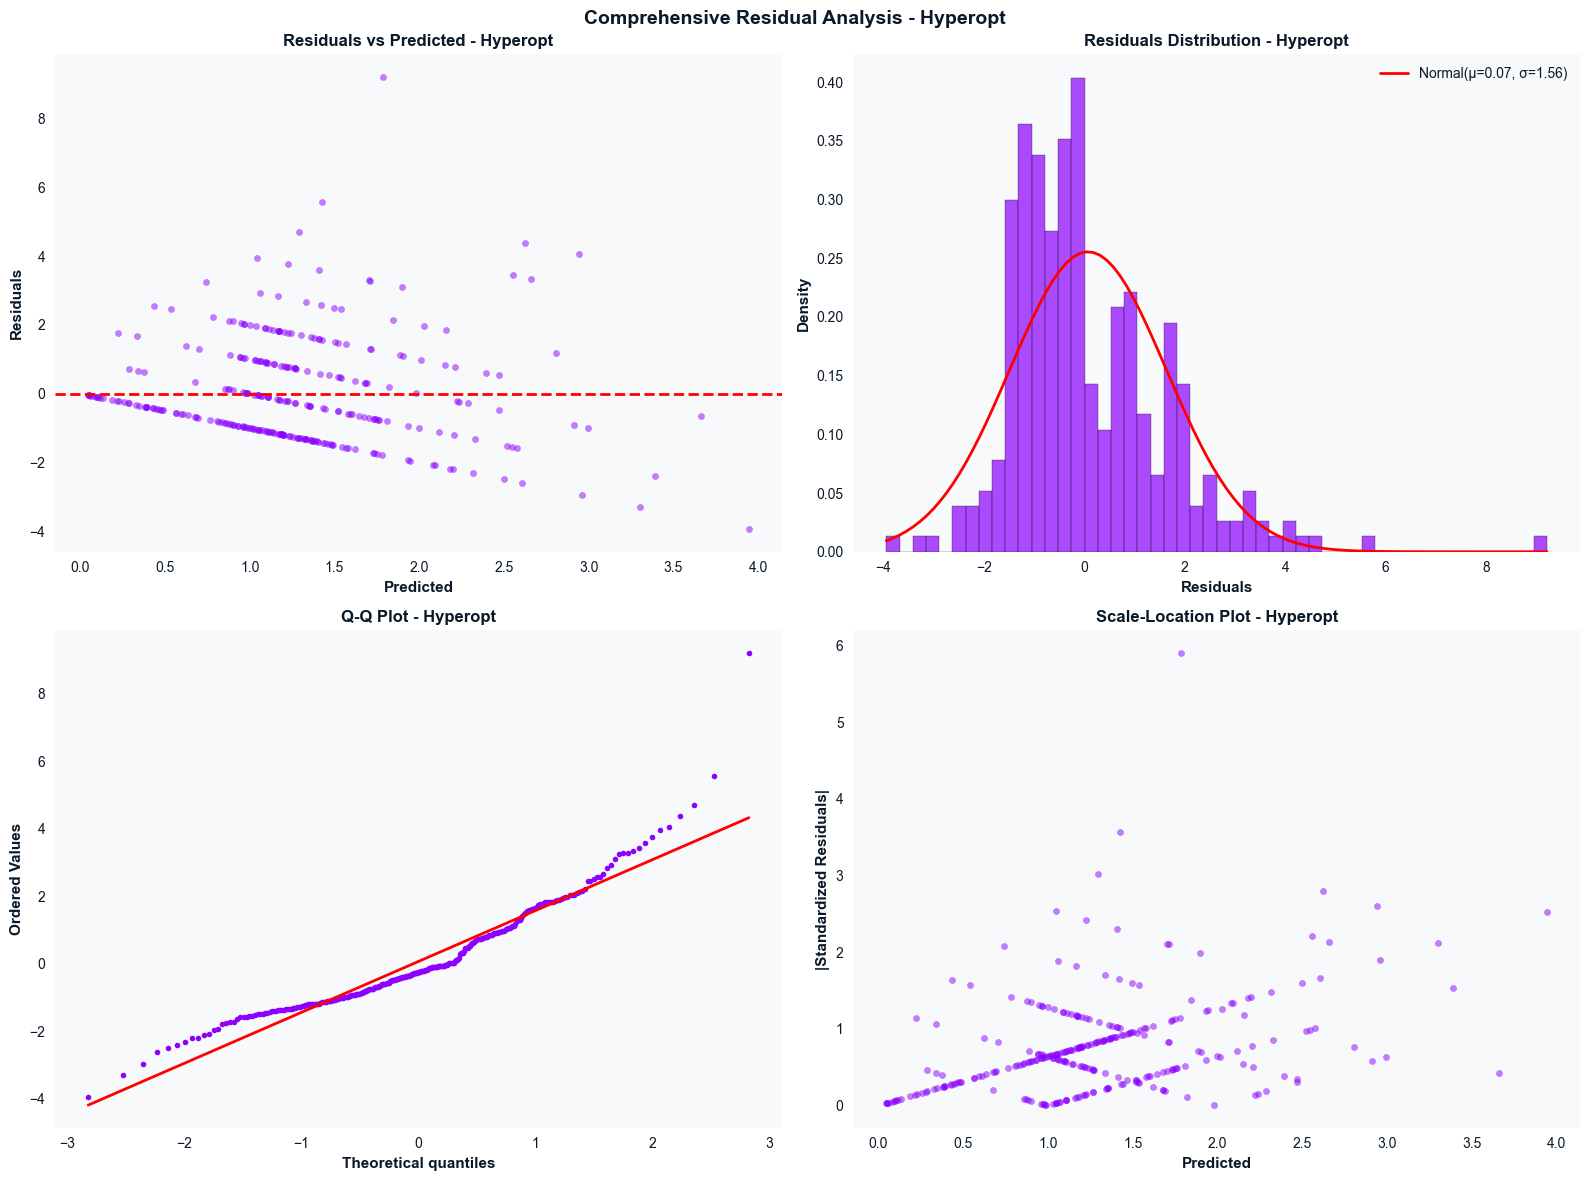

In [15]:
xgb_runner.plot_single_model_analysis(model_name="xgboost_hyperopt")

## 5️⃣ Results Analysis

We now collect the metrics from:

- Baseline
- GridSearchCV
- RandomizedSearchCV
- Hyperopt

and build a comparison table to see which variant performs best on the test set.


### *5.1 Building comparison table*

In [ ]:

print("\n Building comparison table...")
xgb_runner.build_comparison_table()



📊 Building comparison table...
✅ Built comparison table with 4 variants

Comparison Table:
           model     rmse      mae        r2 param_colsample_bytree  param_learning_rate param_max_depth param_n_estimators     param_reg_alpha    param_reg_lambda    param_subsample
  xgboost_random 1.551489 1.155087  0.086273                    1.0 0.007788255587326423               4                335 0.15602015889668858  0.1777541111003925                1.0
xgboost_hyperopt 1.560593 1.177063  0.075518      0.678005662321192  0.00960677021066004               7                300   0.962188302583034 0.00787106199242684 0.7414922190959902
    xgboost_grid 1.609780 1.209780  0.016323                    0.8                 0.03              10                300                   0                   1                0.7
         xgboost 1.629066 1.223404 -0.007387                    NaN                  NaN             NaN                NaN                 NaN                 NaN             

model      rmse       mae        r2 param_colsample_bytree  \
2    xgboost_random  1.551489  1.155087  0.086273                    1.0   
3  xgboost_hyperopt  1.560593  1.177063  0.075518      0.678005662321192   
1      xgboost_grid  1.609780  1.209780  0.016323                    0.8   
0           xgboost  1.629066  1.223404 -0.007387                    NaN   

    param_learning_rate param_max_depth param_n_estimators  \
2  0.007788255587326423               4                335   
3   0.00960677021066004               7                300   
1                  0.03              10                300   
0                   NaN             NaN                NaN   

       param_reg_alpha     param_reg_lambda     param_subsample  
2  0.15602015889668858   0.1777541111003925                 1.0  
3    0.962188302583034  0.00787106199242684  0.7414922190959902  
1                    0                    1                 0.7  
0                  NaN                  NaN                 NaN

### *5.2 Calculating rankings*

In [23]:
print("📊 Calculating rankings...")
xgb_runner.calculate_rankings()
        


📊 Calculating rankings...
✅ Calculated rankings for 3 metrics

Model Rankings:
metric            model     value  rank
  RMSE   xgboost_random  1.551489     1
  RMSE xgboost_hyperopt  1.560593     2
  RMSE     xgboost_grid  1.609780     3
  RMSE          xgboost  1.629066     4
   MAE   xgboost_random  1.155087     1
   MAE xgboost_hyperopt  1.177063     2
   MAE     xgboost_grid  1.209780     3
   MAE          xgboost  1.223404     4
    R2   xgboost_random  0.086273     1
    R2 xgboost_hyperopt  0.075518     2
    R2     xgboost_grid  0.016323     3
    R2          xgboost -0.007387     4


metric             model     value  rank
0    RMSE    xgboost_random  1.551489     1
1    RMSE  xgboost_hyperopt  1.560593     2
2    RMSE      xgboost_grid  1.609780     3
3    RMSE           xgboost  1.629066     4
4     MAE    xgboost_random  1.155087     1
5     MAE  xgboost_hyperopt  1.177063     2
6     MAE      xgboost_grid  1.209780     3
7     MAE           xgboost  1.223404     4
8      R2    xgboost_random  0.086273     1
9      R2  xgboost_hyperopt  0.075518     2
10     R2      xgboost_grid  0.016323     3
11     R2           xgboost -0.007387     4

### *5.3 Saving comparison results*

In [24]:
print("💾 Saving comparison results...")
xgb_runner.save_comparison_results(format="both")
        


💾 Saving comparison results...

📊 MODEL RANKING BY RMSE
                    rmse     mae      r2  rank
xgboost_random    1.5515  1.1551  0.0863     1
xgboost_hyperopt  1.5606  1.1771  0.0755     2
xgboost_grid      1.6098  1.2098  0.0163     3
xgboost           1.6291  1.2234 -0.0074     4

--------------------------------------------------------------------------------
🏆 BEST MODEL: xgboost_random
   → RMSE: 1.5515
   → Full metrics: {'rmse': 1.5515, 'mae': 1.1551, 'r2': 0.0863}


📊 MODEL RANKING BY MAE
                    rmse     mae      r2  rank
xgboost_random    1.5515  1.1551  0.0863     1
xgboost_hyperopt  1.5606  1.1771  0.0755     2
xgboost_grid      1.6098  1.2098  0.0163     3
xgboost           1.6291  1.2234 -0.0074     4

--------------------------------------------------------------------------------
🏆 BEST MODEL: xgboost_random
   → MAE: 1.1551
   → Full metrics: {'rmse': 1.5515, 'mae': 1.1551, 'r2': 0.0863}


📊 MODEL RANKING BY R2
                    rmse     mae      

### *5.4 Logging comparison to MLflow*

In [ ]:
print("📈 Logging comparison to MLflow...")
xgb_runner.log_comparison_to_mlflow()



## 6️⃣ Visual comparison of model performance

Using `ModelVisualizer` (via `XGBoostRunner`), we generate:

- Multi‑model comparison plots
- Multi‑model actual vs predicted
- Time series overlays
- Error distribution comparison
- Radar plot of performance metrics

These plots are also saved to the visualization directory.



GENERATING XGBOOST MODEL COMPARISON PLOTS
📊 Generating multi-model comparison...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/xgboost/07_multi_model_comparison.png


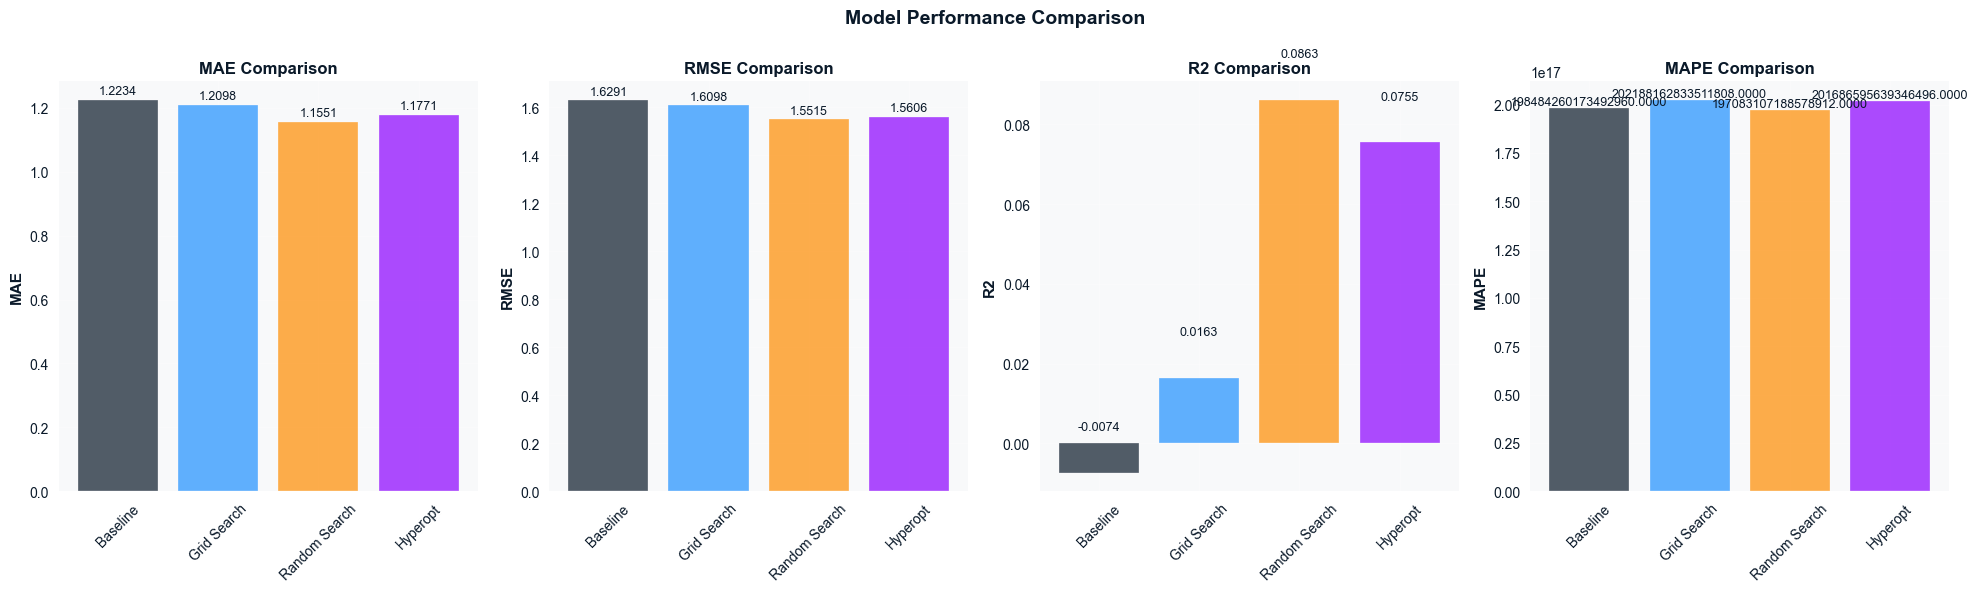

📊 Generating multi-model actual vs predicted...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/xgboost/08_multi_model_actual_vs_predicted.png


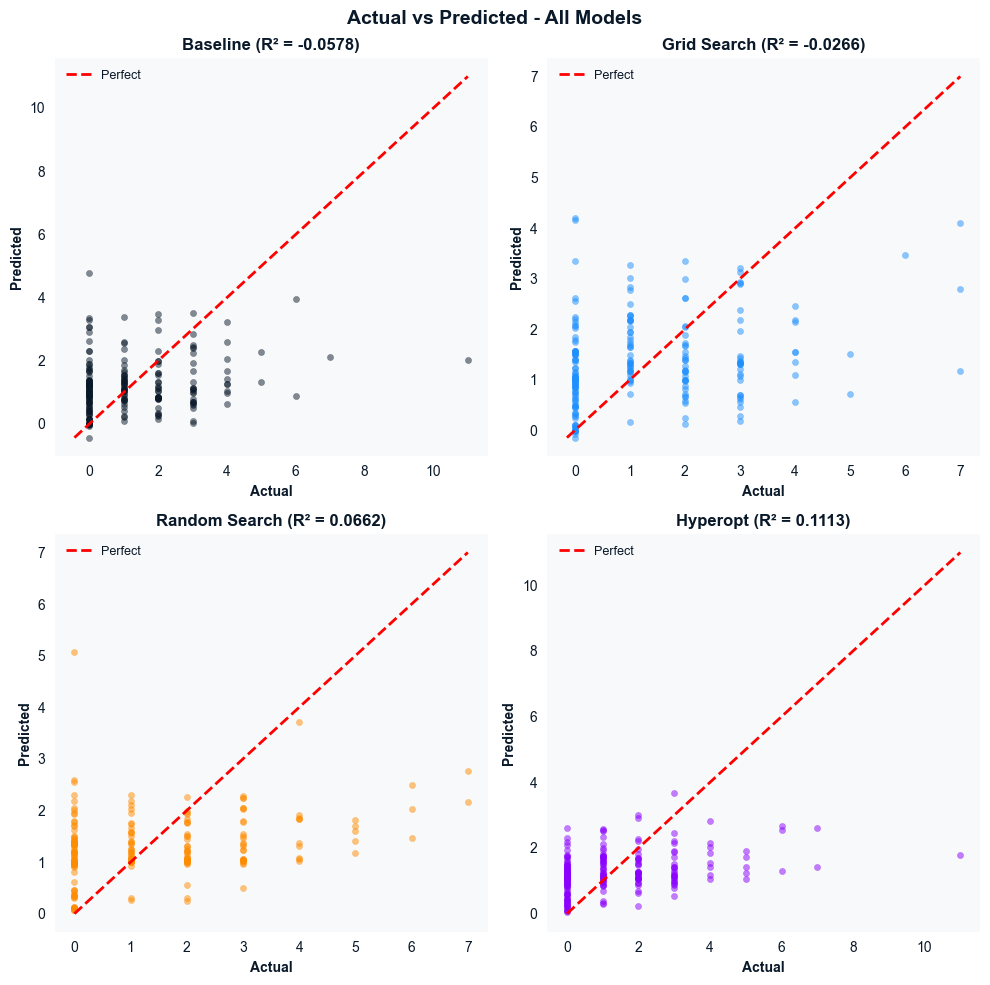

📊 Generating multi-model time series comparison...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/xgboost/09_multi_model_time_series_comparison.png


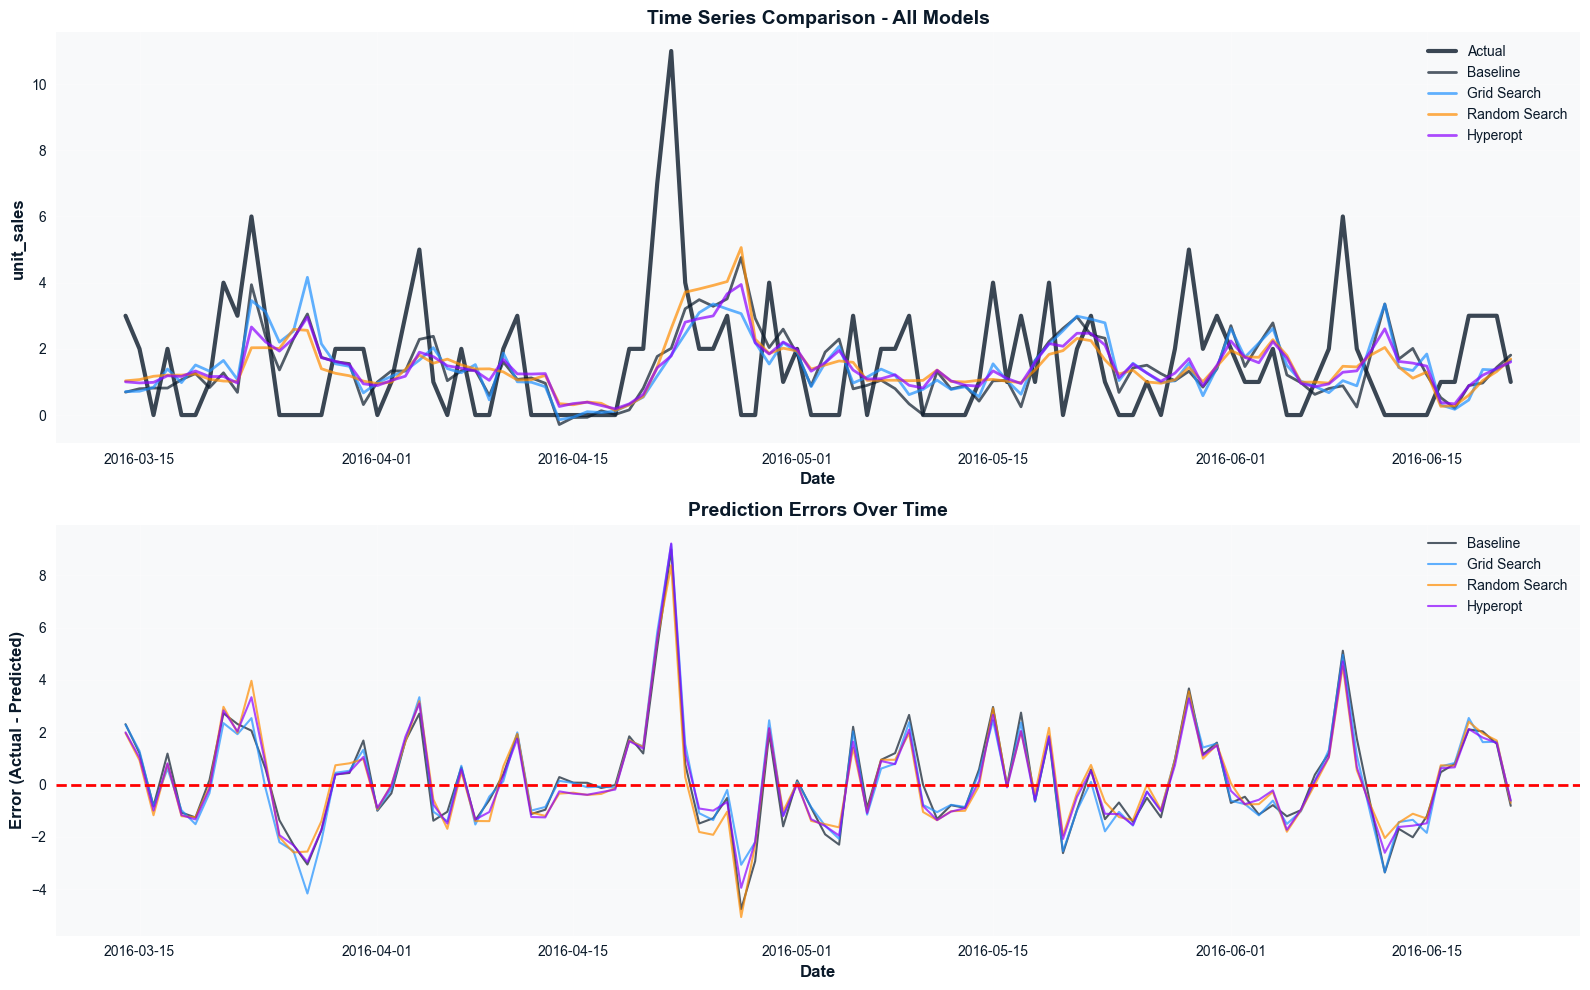

📊 Generating error distribution comparison...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/xgboost/11_error_distribution_comparison.png


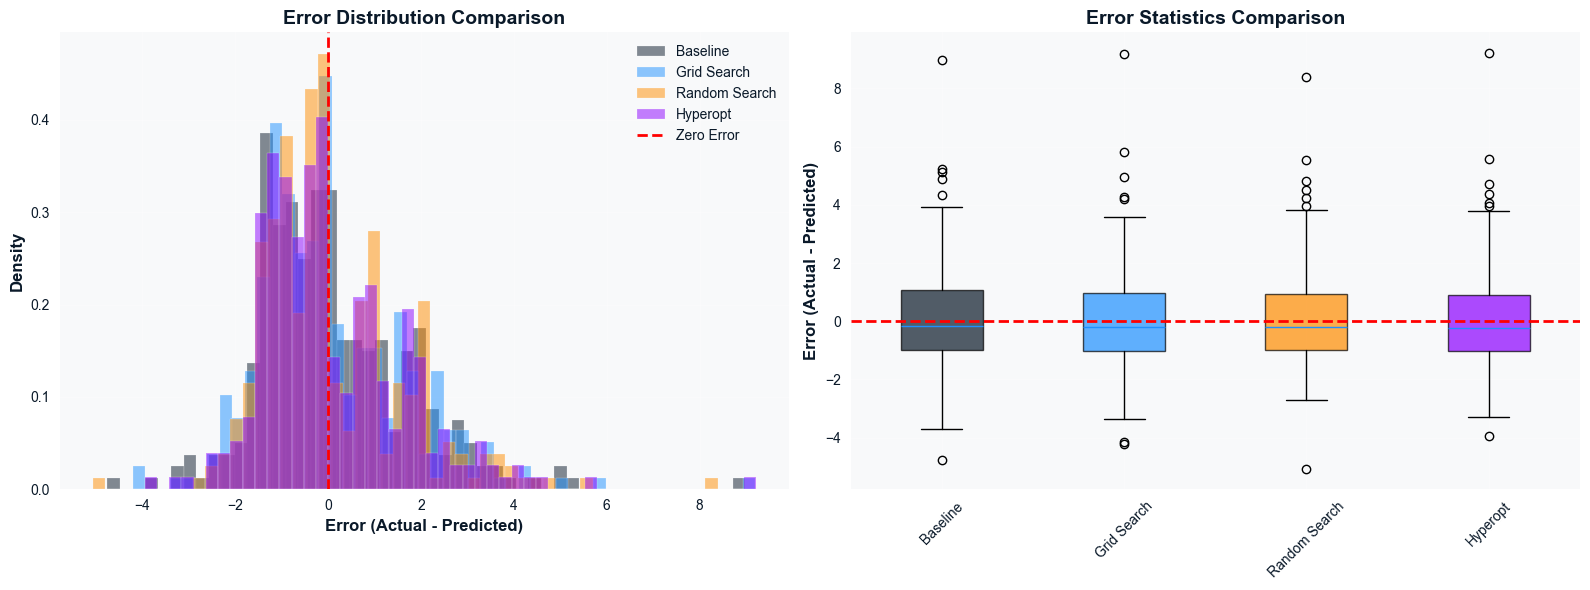

📊 Generating daily overlay subplots...

[DEBUG][plot_all_predictions_overlay_daily] Starting daily overlay subplot plot...
[DEBUG] y_true, dates, and model_predictions validated.
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/xgboost/14_all_predictions_overlay_daily_subplots.png


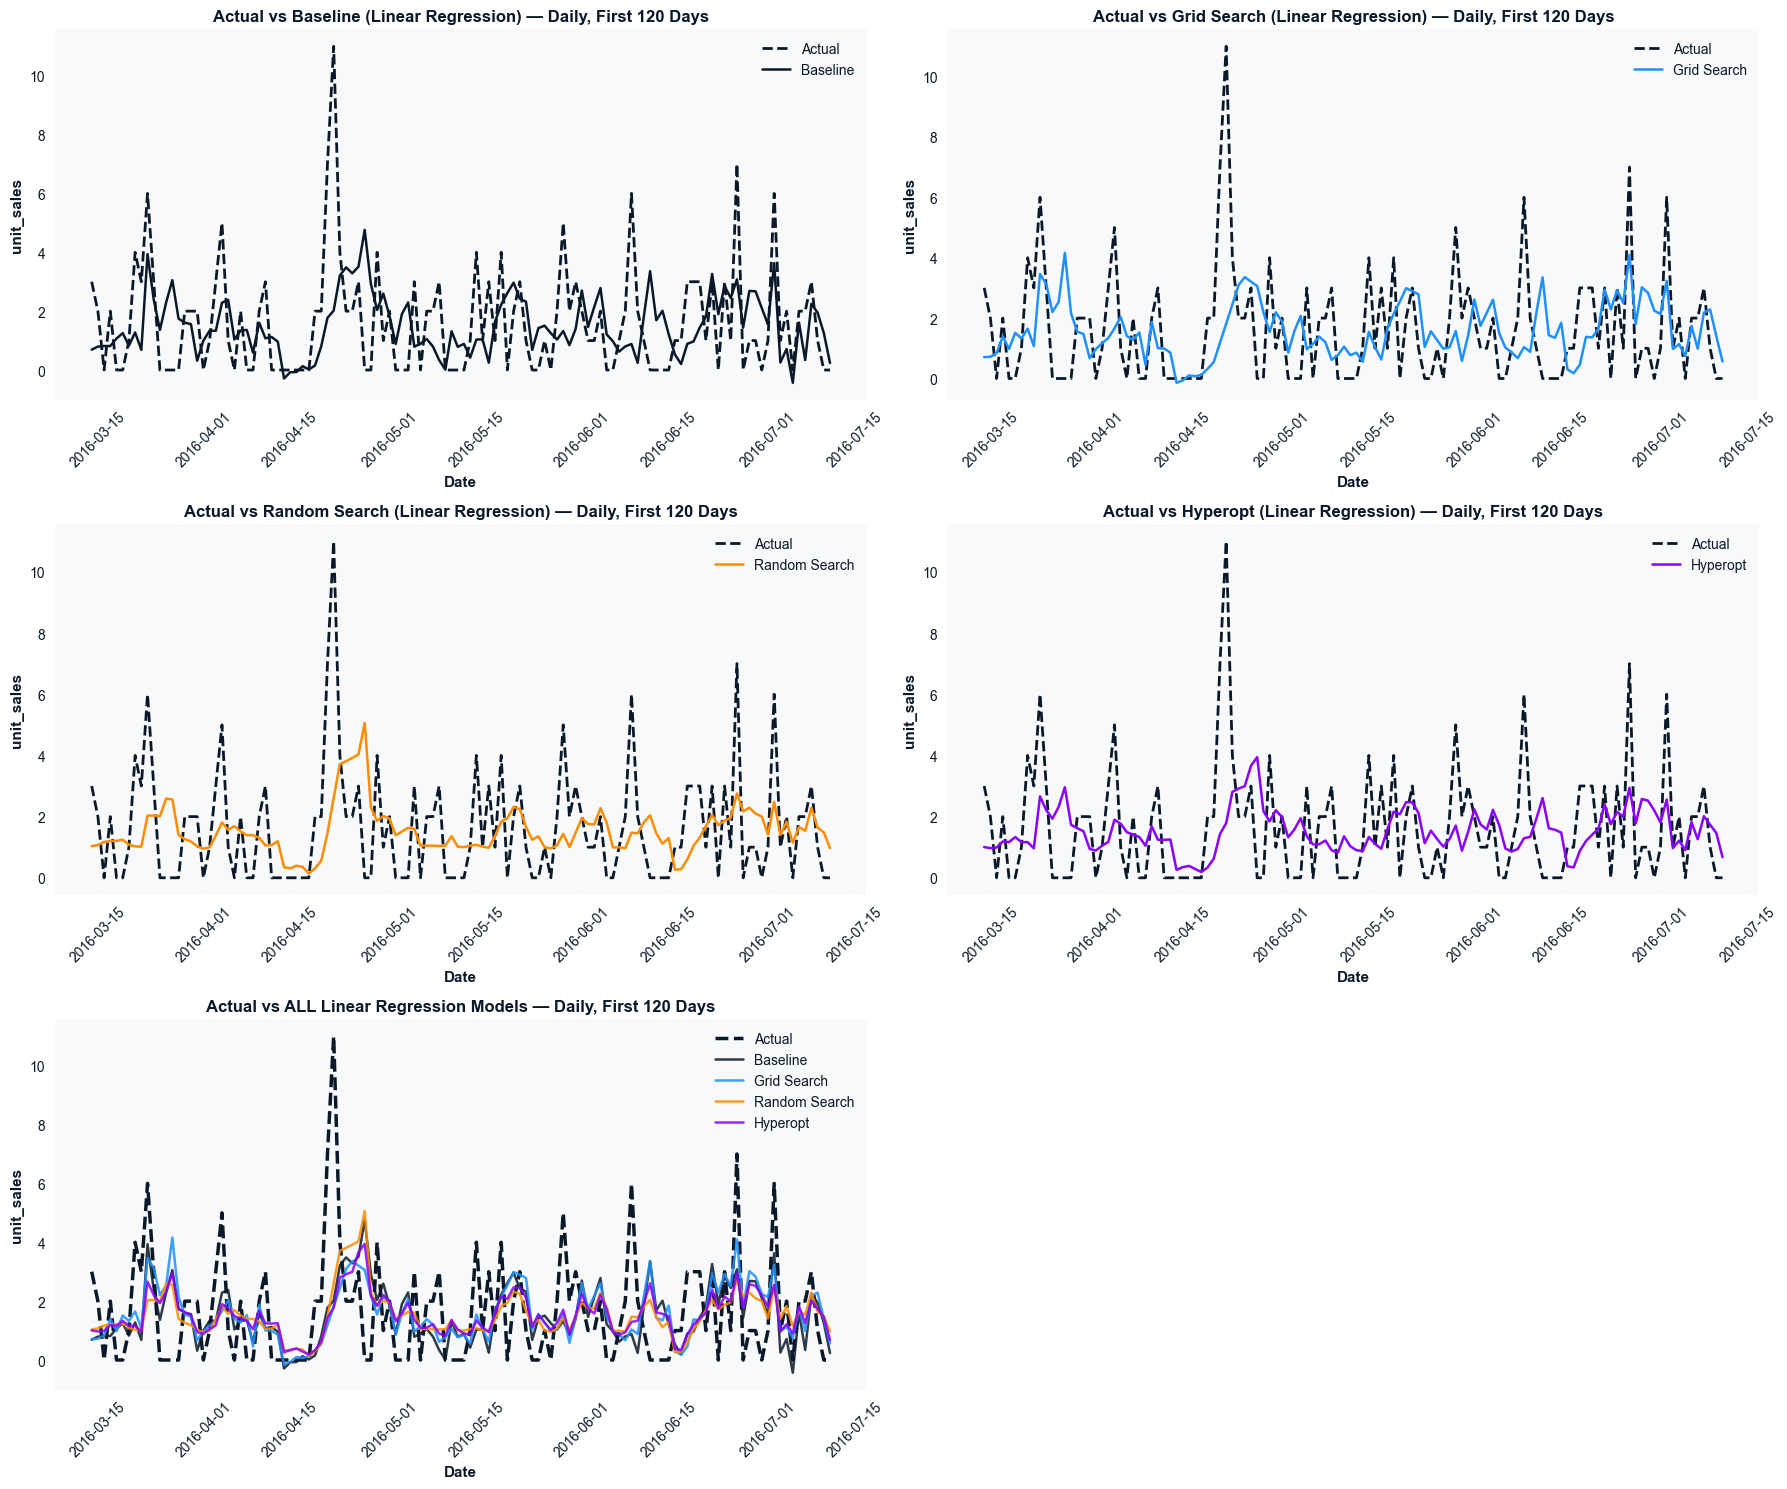

[DEBUG][plot_all_predictions_overlay_daily] Completed.

📊 Generating monthly overlay...

[DEBUG][plot_all_predictions_overlay_monthly] Starting monthly overlay plot...
[DEBUG] y_true, dates, and model_predictions validated.
[DEBUG] y_true length: 292
[DEBUG] Base DataFrame shape: (292, 2)
[DEBUG] Processing model: xgboost → display name: Baseline
[DEBUG] Converting predictions of xgboost to pandas Series.
[DEBUG] Aligning lengths → min_len = 292
[DEBUG] Added column 'Baseline' to DataFrame.
[DEBUG] Processing model: xgboost_grid → display name: Grid Search
[DEBUG] Converting predictions of xgboost_grid to pandas Series.
[DEBUG] Aligning lengths → min_len = 292
[DEBUG] Added column 'Grid Search' to DataFrame.
[DEBUG] Processing model: xgboost_random → display name: Random Search
[DEBUG] Converting predictions of xgboost_random to pandas Series.
[DEBUG] Aligning lengths → min_len = 292
[DEBUG] Added column 'Random Search' to DataFrame.
[DEBUG] Processing model: xgboost_hyperopt → display

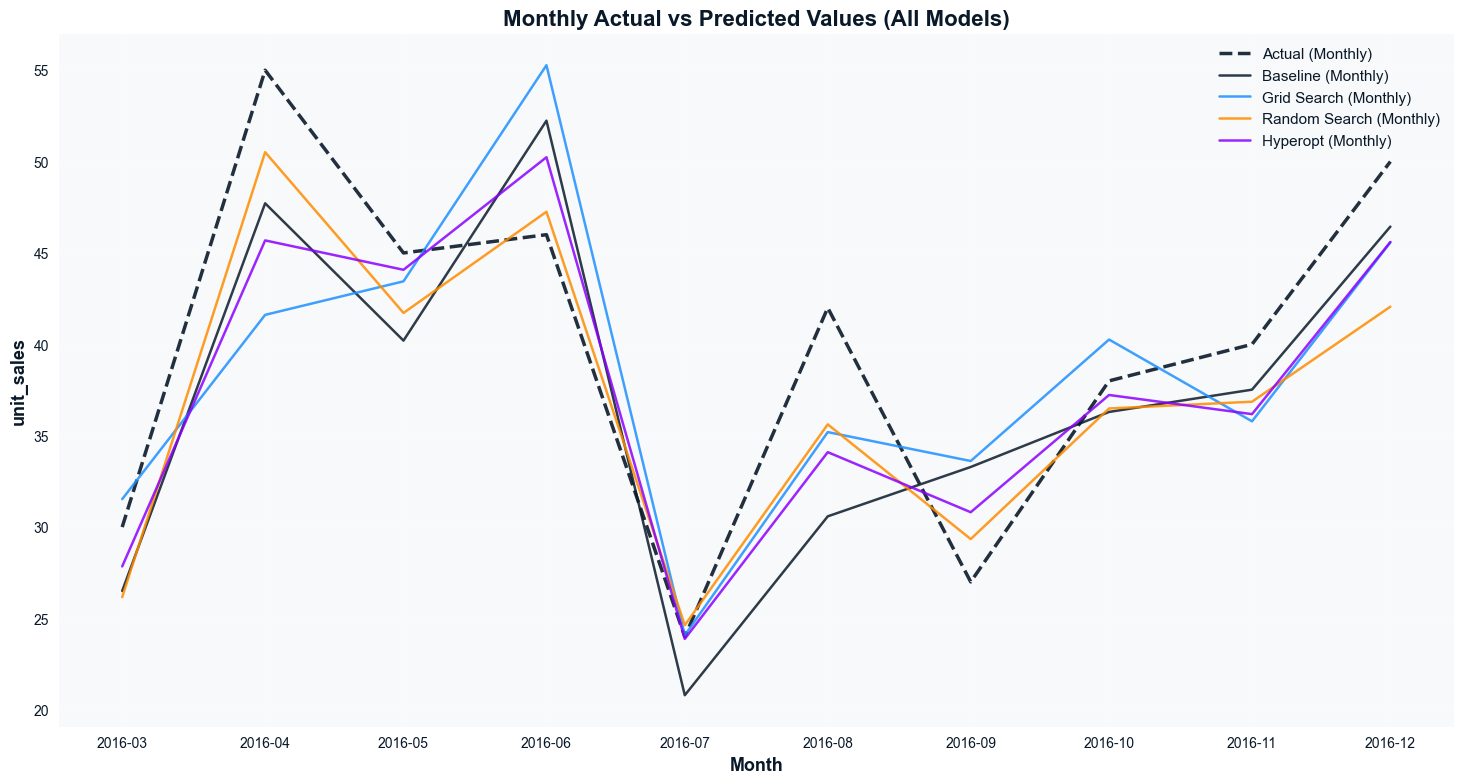

[DEBUG][plot_all_predictions_overlay_monthly] Completed.

📊 Generating model performance radar...
📁 Saved plot: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/xgboost/10_model_performance_radar.png


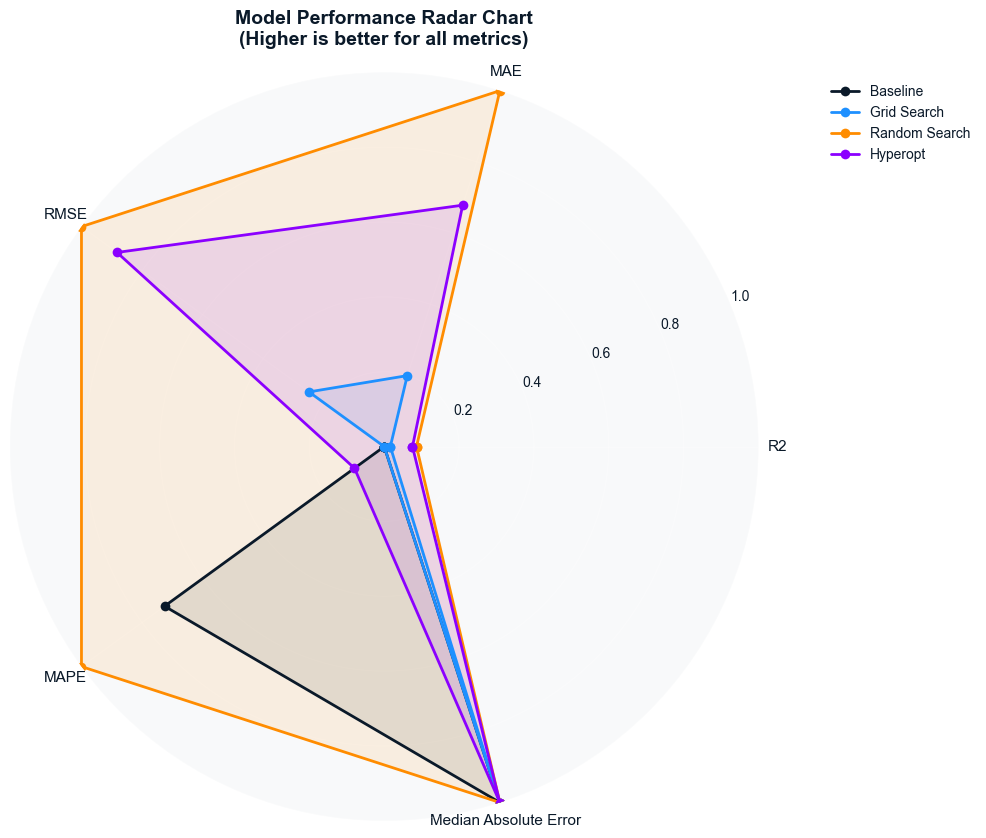


✅ XGBoost comparison plots generation complete!



In [18]:
xgb_runner.plot_model_comparison()


## 7️⃣ Feature importance analysis

For each trained variant, we inspect **feature importance**:

- Top‑N most important features
- Horizontal bar plots with importance values
- Saved PNG files for documentation

This helps interpret what the model is relying on.


🎯 FEATURE IMPORTANCE ANALYSIS

📊 BASELINE MODEL FEATURE IMPORTANCE:

📊 Top 15 Feature Importance for xgboost_random (type: weight):
            feature  importance feature_key  importance_pct
 unit_sales_r7_mean      1005.0          f5       25.546518
  unit_sales_r7_std       769.0          f8       19.547534
unit_sales_r30_mean       426.0          f7       10.828673
        day_of_week       326.0          f9        8.286731
 days_until_holiday       304.0         f11        7.727504
 days_since_holiday       248.0         f12        6.304016
unit_sales_r14_mean       241.0          f6        6.126080
  unit_sales_lag_30       193.0          f3        4.905948
   unit_sales_lag_7       181.0          f1        4.600915
  unit_sales_lag_14       166.0          f2        4.219624
 unit_sales_lag_365        61.0          f4        1.550585
              month        14.0         f10        0.355872

Total features with importance: 12
Sum of importance: 3934.0000
💾 Feature importance sa

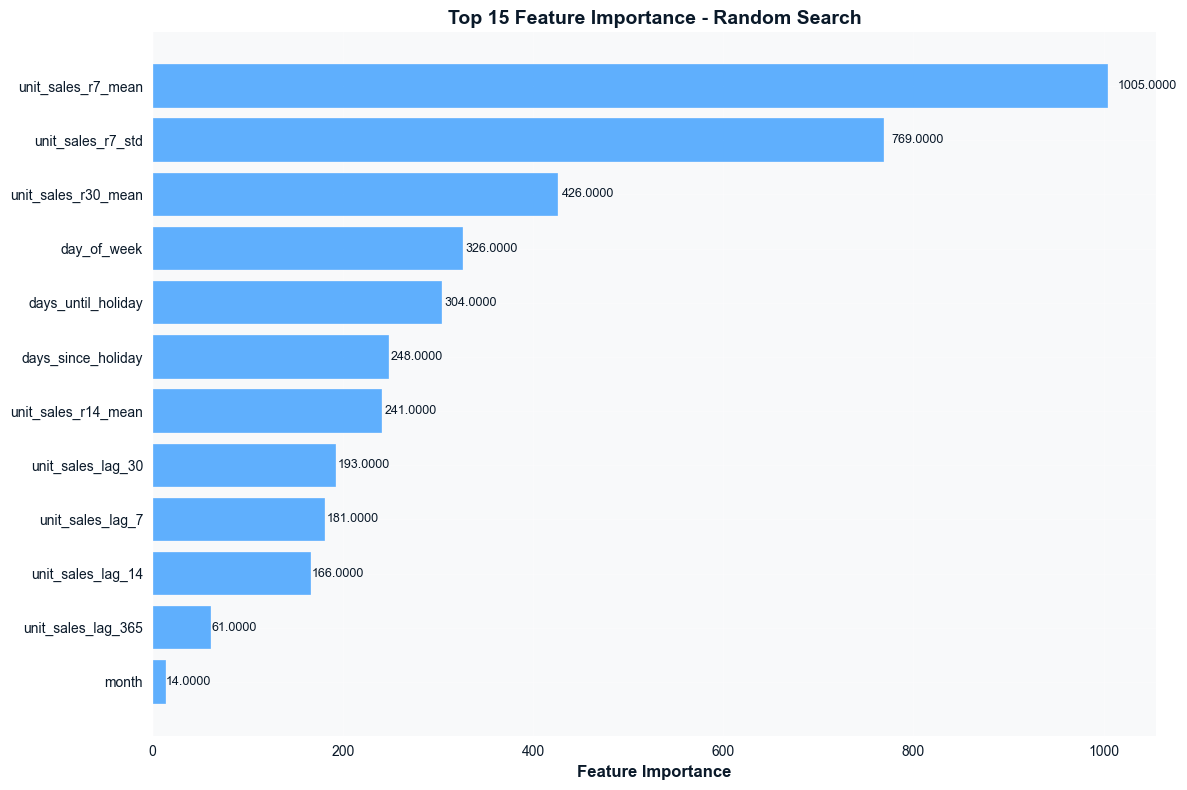

✅ Feature importance plot saved: feature_importance_xgboost_random.png

📊 COMPARING FEATURE IMPORTANCE ACROSS MODELS:

📊 Top 5 Feature Importance for xgboost (type: weight):
            feature  importance feature_key  importance_pct
 unit_sales_r7_mean      5024.0          f5       10.667799
   unit_sales_lag_7      4907.0          f1       10.419365
  unit_sales_r7_std      4876.0          f8       10.353541
unit_sales_r14_mean      4539.0          f6        9.637966
unit_sales_r30_mean      4359.0          f7        9.255760

Total features with importance: 13
Sum of importance: 47095.0000
💾 Feature importance saved: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/xgboost/xgboost_feature_importance_weight.csv

xgboost:
               feature  importance
5   unit_sales_r7_mean      5024.0
1     unit_sales_lag_7      4907.0
8    unit_sales_r7_std      4876.0
6  unit_sales_r14_mean      4539.0
7  unit_sales_r30_mea

In [19]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================

print("🎯 FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Get feature importance for baseline model
print("\n📊 BASELINE MODEL FEATURE IMPORTANCE:")
importance_df = xgb_runner.get_feature_importance("xgboost_random", top_n=15)
print(importance_df)

# Plot feature importance
xgb_runner.plot_feature_importance_analysis("xgboost_random", top_n=15)
# Compare feature importance across models
print("\n📊 COMPARING FEATURE IMPORTANCE ACROSS MODELS:")
for variant in xgb_runner.MODEL_VARIANTS:
    if variant in xgb_runner._trained_variants:
        importance = xgb_runner.get_feature_importance(variant, top_n=5)
        print(f"\n{variant}:")
        print(importance[['feature', 'importance']].head())




## 8️⃣ Forecasting Future Sales with XGBoost

In this section, we generate **future forecasts** using the trained XGBoost models.

The forecasting API is designed to:

- Generate future dates
- Build feature rows for those dates
- Apply the same preprocessing pipeline
- Predict future sales using any trained model variant
- Return a clean forecast DataFrame

⚠️ *Note:* The method `forecast_future()` must exist inside `XGBoostRunner`.  
These cells will not run until that method is implemented.


In [20]:
# =============================================================================
# FUTURE FORECASTING
# =============================================================================

print("🔮 FUTURE FORECASTING WITH RANDOM FOREST")
print("=" * 50)

# Generate 30-day forecast using the best model
forecast_results = xgb_runner.forecast_future(
    forecast_horizon=30,        # Forecast 30 periods
    frequency="D",              # Daily frequency
    variant_name=None,          # Use best model automatically
    confidence_level=0.95,      # 95% confidence interval
    n_bootstrap=100              # Bootstrap samples for uncertainty
)

print("\n📊 FORECAST RESULTS SUMMARY:")
print(f"Model used: {forecast_results['model_variant']}")
print(f"Forecast horizon: {forecast_results['forecast_horizon']} days")
print(f"Mean forecast: {forecast_results['statistics']['mean_forecast']:.2f}")

🔮 FUTURE FORECASTING WITH RANDOM FOREST

🔮 XGBOOST FUTURE FORECASTING

📊 MODEL RANKING BY RMSE
                    rmse     mae      r2  rank
xgboost_random    1.5515  1.1551  0.0863     1
xgboost_hyperopt  1.5606  1.1771  0.0755     2
xgboost_grid      1.6098  1.2098  0.0163     3
xgboost           1.6291  1.2234 -0.0074     4

--------------------------------------------------------------------------------
🏆 BEST MODEL: xgboost_random
   → RMSE: 1.5515
   → Full metrics: {'rmse': 1.5515, 'mae': 1.1551, 'r2': 0.0863}

📊 Using best model: xgboost_random
📅 Preparing future features for 30 periods...
✅ Future features prepared: (30, 14)
📈 Generating point forecasts...
🎲 Estimating uncertainty with bootstrap...
   Running 100 bootstrap iterations...
💾 Forecast saved to CSV: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/xgboost/xgboost_random_forecast_30periods.csv
💾 Forecast metadata saved: /Users/guykaptue/my_work_

### *8.1 Plot forecast vs historical data*

This visualization overlays:

- Historical sales
- Future forecast

This helps evaluate continuity and detect jumps or anomalies.




📊 GENERATING COMPREHENSIVE FORECAST REPORT

🔮 XGBOOST FUTURE FORECASTING

📊 MODEL RANKING BY RMSE
                    rmse     mae      r2  rank
xgboost_random    1.5515  1.1551  0.0863     1
xgboost_hyperopt  1.5606  1.1771  0.0755     2
xgboost_grid      1.6098  1.2098  0.0163     3
xgboost           1.6291  1.2234 -0.0074     4

--------------------------------------------------------------------------------
🏆 BEST MODEL: xgboost_random
   → RMSE: 1.5515
   → Full metrics: {'rmse': 1.5515, 'mae': 1.1551, 'r2': 0.0863}

📊 Using best model: xgboost_random
📅 Preparing future features for 30 periods...
✅ Future features prepared: (30, 14)
📈 Generating point forecasts...
🎲 Estimating uncertainty with bootstrap...
   Running 100 bootstrap iterations...
💾 Forecast saved to CSV: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/xgboost/xgboost_random_forecast_30periods.csv
💾 Forecast metadata saved: /Users/guykaptue/my_w

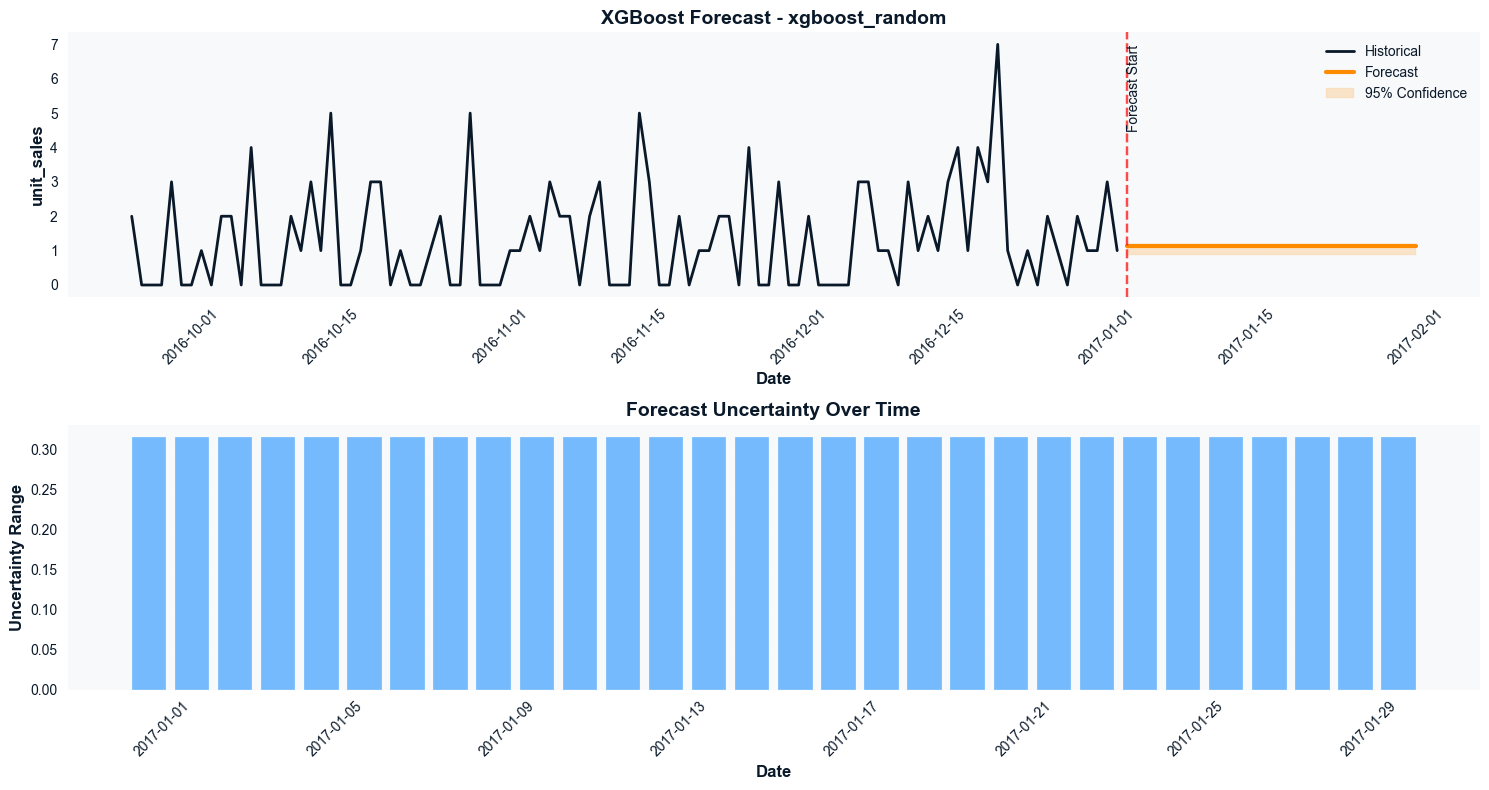

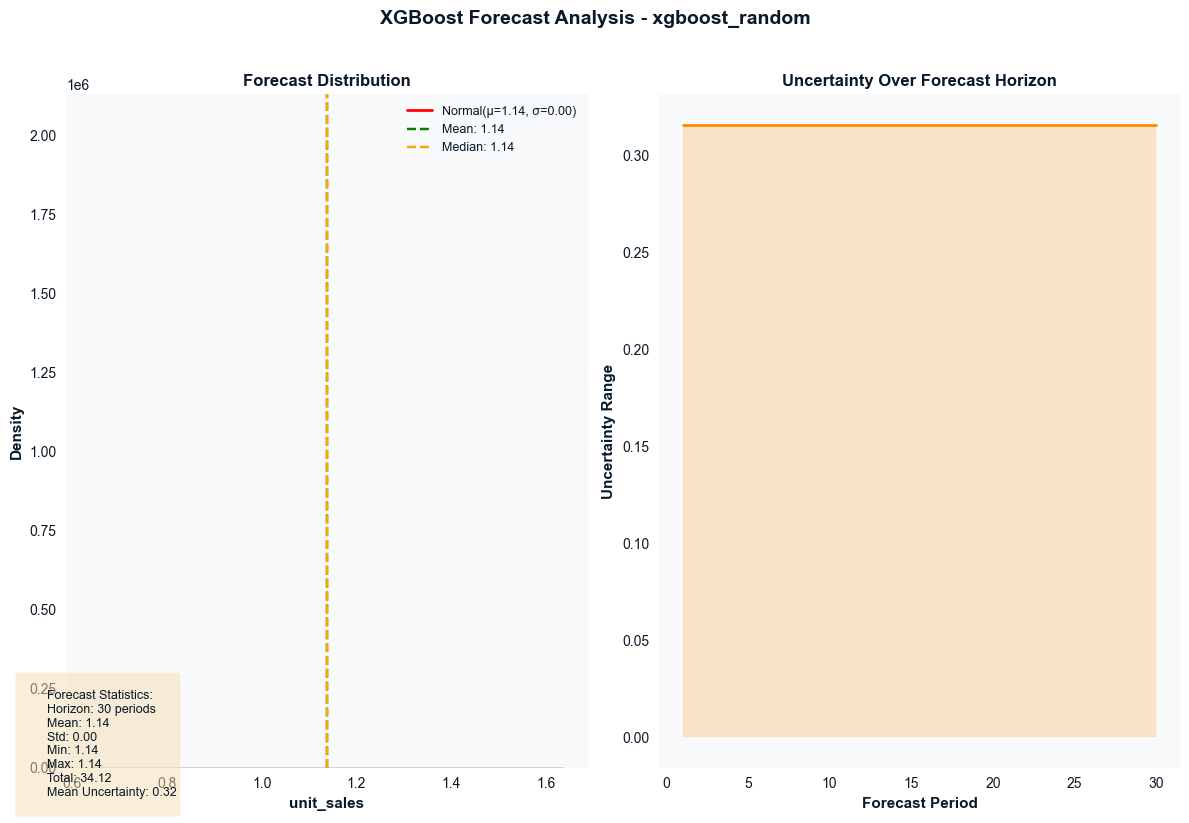

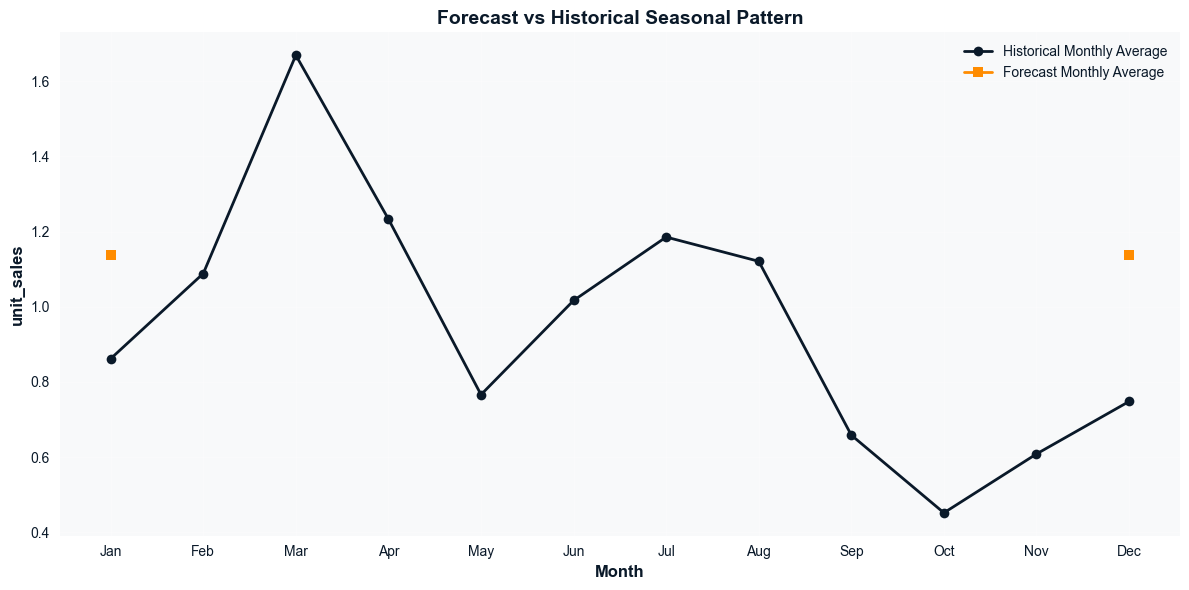

   📋 Creating forecast summary...

FORECAST SUMMARY TABLE
Model Variant                 : xgboost_random
Forecast Horizon              : 30 periods
Frequency                     : D
Confidence Level              : 95.0%
Mean Forecast                 : 1.14
Median Forecast               : 1.14
Std Forecast                  : 0.00
Min Forecast                  : 1.14
Max Forecast                  : 1.14
Total Forecast                : 34.12
Mean Uncertainty              : 0.32
Uncertainty Ratio             : 0.278

First 10 Forecast Values:
----------------------------------------
Date            Point Forecast  Lower Bound     Upper Bound    
----------------------------------------
2016-12-31                 1.14            0.87            1.18
2017-01-01                 1.14            0.87            1.18
2017-01-02                 1.14            0.87            1.18
2017-01-03                 1.14            0.87            1.18
2017-01-04                 1.14            0.87      

In [28]:
# Generate comprehensive forecast report
complete_forecast = xgb_runner.generate_forecast_report(
    forecast_horizon=30,
    frequency="D",
)

## 9️⃣ SUMMARIZATION METHODS

In [29]:
xgb_runner.summarize_pipeline()


🚀 XGBOOST PIPELINE — SYSTEM SUMMARY

📊 DATA SUMMARY
----------------------------------------------------------------------------------------------------
• Week: 3
• Target variable: unit_sales
• Training samples: 1,167
• Test samples: 292
• Number of features: 14
• Store IDs: [24]
• Item IDs: [105577]
• Max date used for training: 2016-12-31

📁 PATHS
----------------------------------------------------------------------------------------------------
• Results saved in:        /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_3/xgboost
• Model files saved in:    /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_3/xgboost
• Visualizations saved in: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_3/xgboost

🤖 TRAINED MODELS
---------------------------------------------------